# Filtering and analyzing EMG data 

### Noel Isaías Plascencia Díaz<sup>1</sup>, Mitsui Myrna Salgado Saito<sup>2</sup>, Ana Daniela del Río Pulido<sup>3</sup>, and Erin C. McKiernan<sup>4</sup>

<sup>1</sup> Licenciatura en Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>2</sup> Licenciatura en Ciencias de la Tierra, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>3</sup> Licenciatura en Física Biomédica, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>
<sup>4</sup> Departamento de Física, Facultad de Ciencias, Universidad Nacional Autónoma de México<br/>

## Overview

The objective of this data analysis practical is to learn how to filter EMG recordings and do some preliminary analysis. The recordings to be analyzed can be found in our GitHub repository (https://github.com/emckiernan/electrophys), or new recordings can be obtained by performing the 'EMG basics' laboratory practical from this series. Before carrying out this analysis practical, students should first do the 'Graphing and exploring EMG data' practical.

## Setting up the notebook

We begin by setting up the Jupyter notebook and importing the Python modules for plotting figures. We include commands to view plots in the notebook, and to create figures with good resolution and large labels.

In [121]:
# command to view figures in Jupyter notebook
%matplotlib inline 

# import plotting module 
import matplotlib.pyplot as plt 

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 20 # fontsize for figure titles
plt.rcParams['font.size'] = 16 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.6 # line width for plotting

Next, we import the necesssary modules and features to perform computations, filter data, etc.

In [122]:
# import modules
import math
import numpy as np
import scipy as sc
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt
import wave

## Extracting and graphing the data

EMG recordings were obtained using the Backyard Brains EMG Spiker Box, and are saved as audio files in .wav format. We will use the same basic function as used in the 'Graphing and exploring EMG data' practical to extract and graph our data, with some extra commands to save relevant values needed for subsequent calculations.

In [123]:
def EMG(file):
    # open .wav file by specifying the path and filename
    record = wave.open(file)
    # extract number of channels, sample rate, data
    numChannels = record.getnchannels() # number of channels
    N = record.getnframes() # number of frames
    sampleRate = record.getframerate() # sampling rate
    # extract data from the .wav file
    dstr = record.readframes(N * numChannels)
    waveData = np.frombuffer(dstr, np.int16)
    # print the number of channels and sample rate
    print('The recording has %d channel(s).' % (numChannels))
    print('The sampling rate of the recording is %d Hz.' % (sampleRate))
    # calculate time window
    timeEMG=np.linspace(0, len(waveData)/sampleRate, num=len(waveData))
    # calculate frequency
    freq = 1/np.mean(np.diff(timeEMG))
    # save relevant data in array
    xx={'sampleRate':sampleRate,\
        'waveData':waveData,\
        'timeEMG':timeEMG,\
        'freq':freq} 
    # plot EMG
    plt.figure(figsize=(18,6))
    plt.xlabel(r'time (s)')
    plt.ylabel(r'voltage ($\mu$V)')
    plt.plot(xx['timeEMG'],xx['waveData'], 'b')
    plt.xlim(0,max(xx['timeEMG']));
    
    return xx

Using our function, we can now dive into our repository of recordings. The following recording was made from the calf muscle during repeated calf raises.

The recording has 1 channel(s).
The sampling rate of the recording is 44100 Hz.


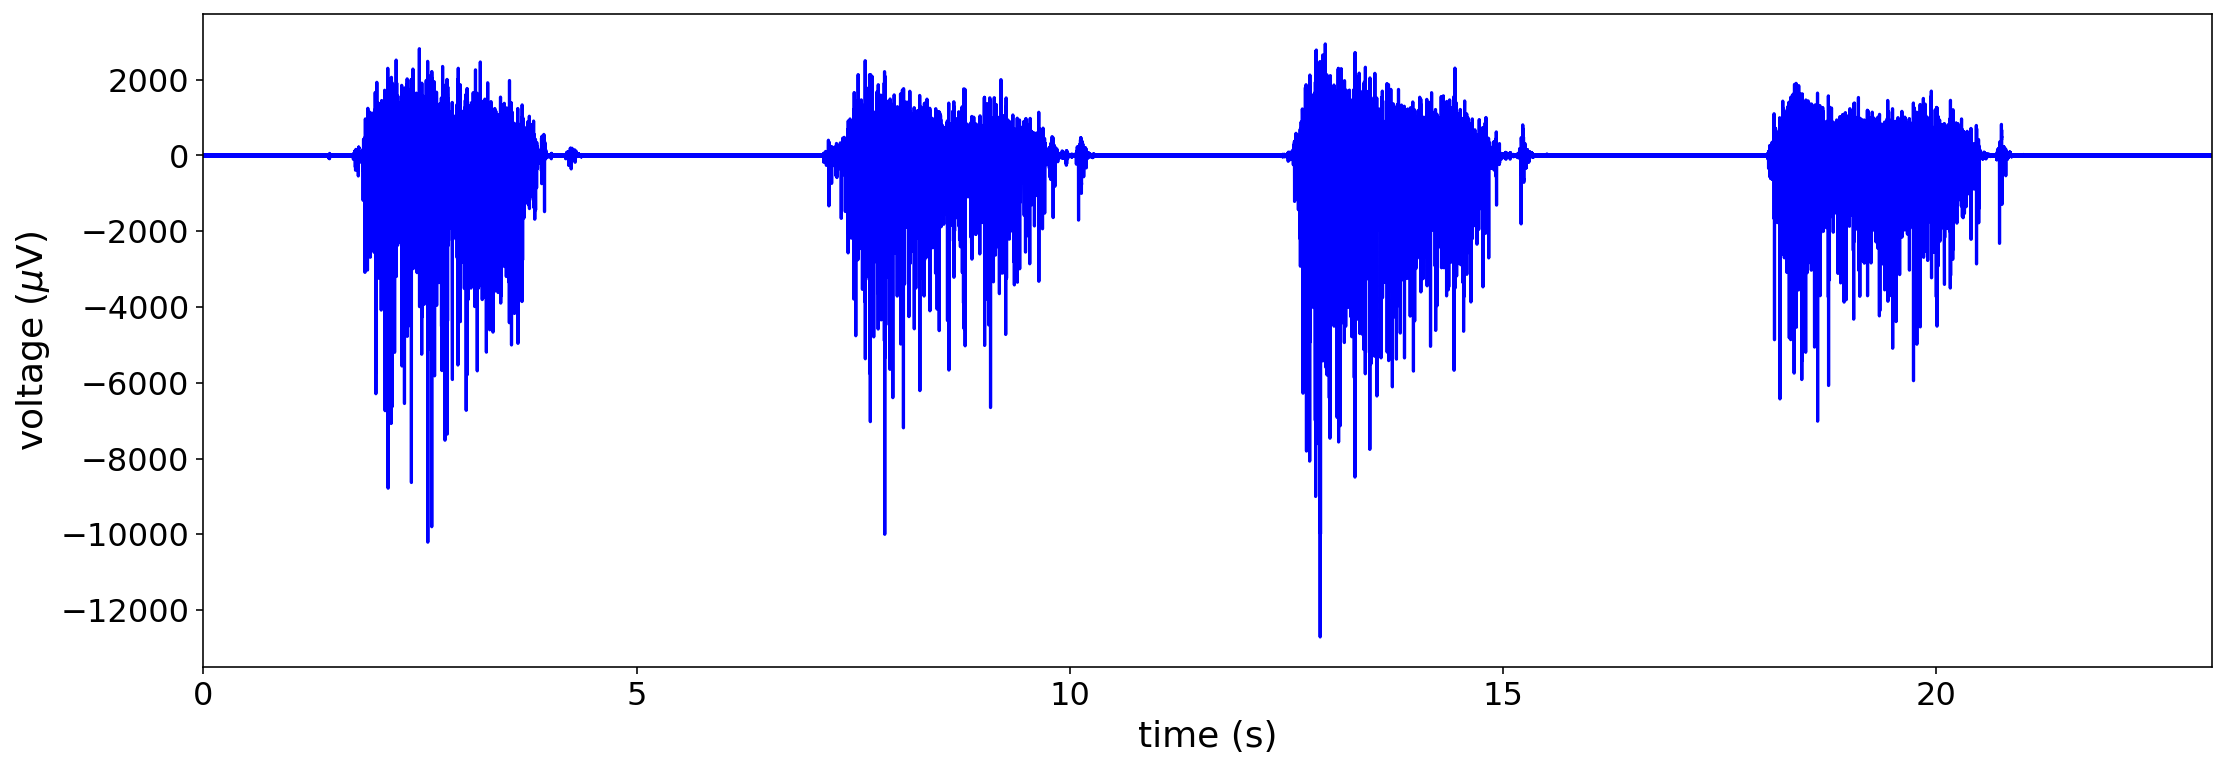

In [124]:
xx = EMG(file='../data/S10_EMG_calf_intermittent.wav')

## Filtering the recordings

Many EMG recordings include a certain level of noise, which can interfere with analysis. For this reason, EMG data is often filtered before proceeding. One of the most common ways to filter EMG data is by applying a band-pass filter, which preserves frequencies inside the specified range and excludes frequencies outside the range. The following functions are used to pass our raw data through a band-pass filter at 10-400 Hz.

In [125]:
# band-pass Butterworth filter at 10-400Hz
b, a = butter(2, ([10, 400]/(xx['freq']/2)), btype = 'bandpass')
dataf = filtfilt(b, a, xx['waveData'])

Plotting a small time window (100 ms) with the raw (blue) and filtered (red) recordings overlapping, we can see the effects of the band-pass filtering.

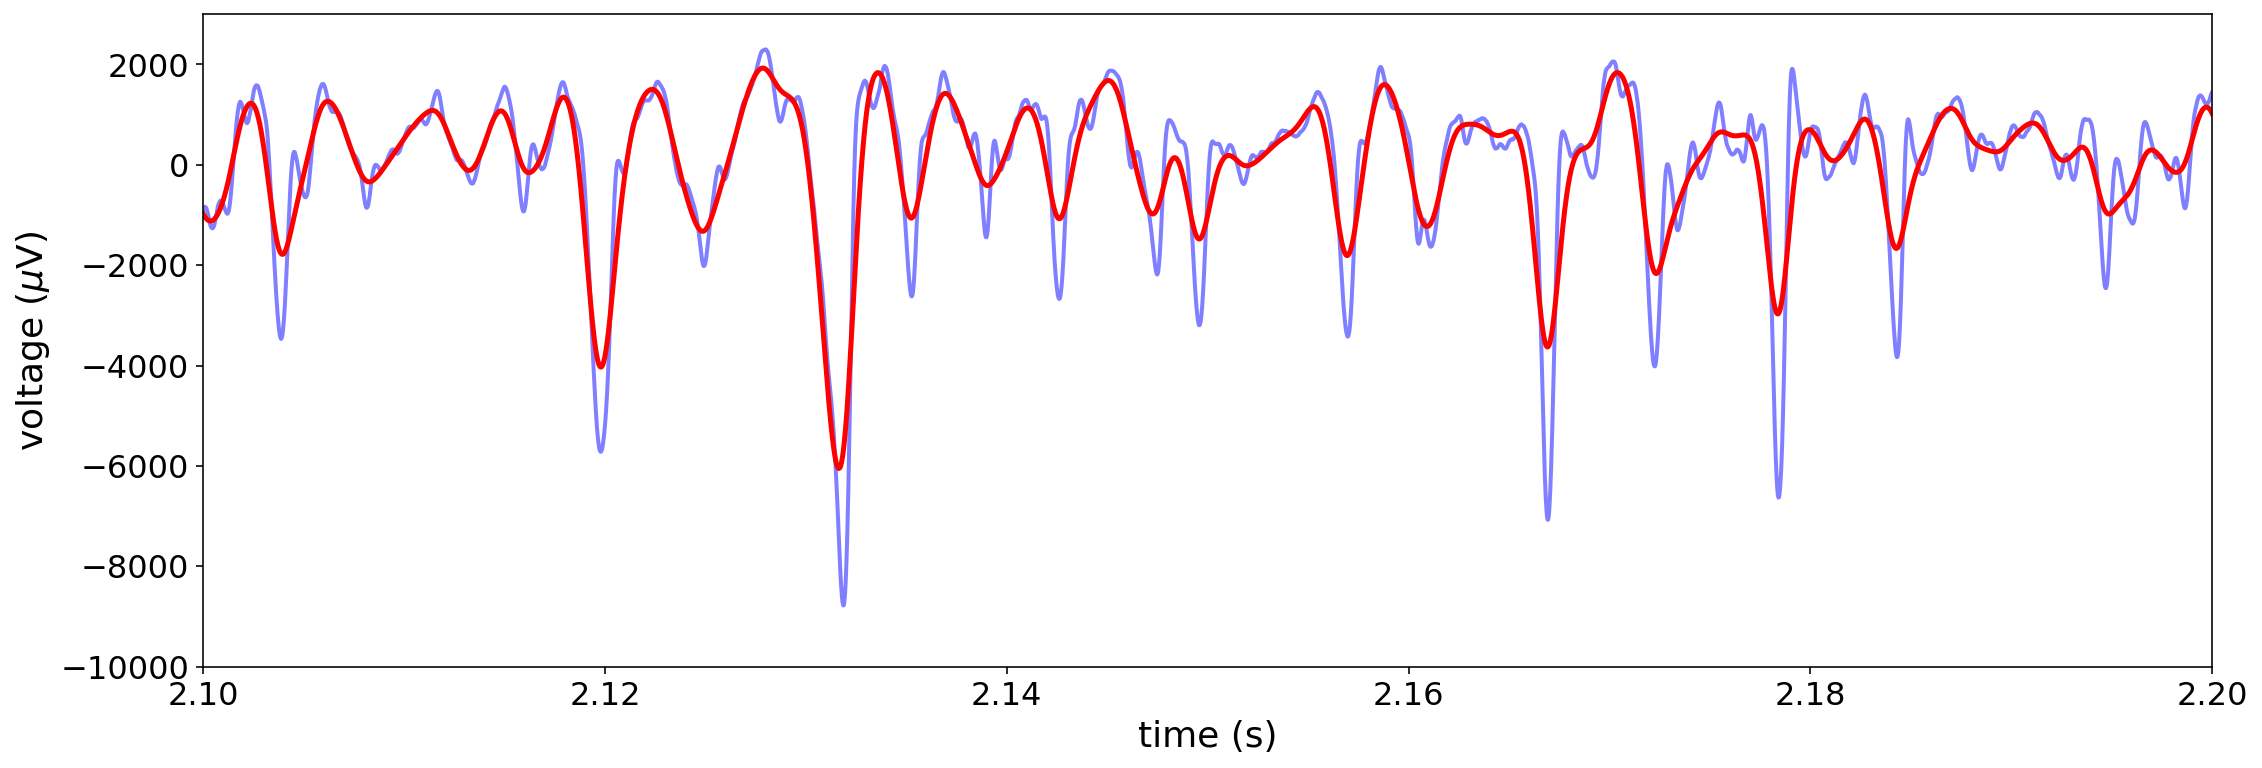

In [126]:
# plot EMG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(xx['timeEMG'],xx['waveData'], 'b', linewidth=2.0, alpha=0.5)
plt.plot(xx['timeEMG'],dataf, 'r', linewidth=2.5)
plt.xlim(2.1,2.2)
plt.ylim(-10000,3000);

Or, we can plot a larger time window (500 ms) with the recordings in separate panels to see other effects of the filtering.

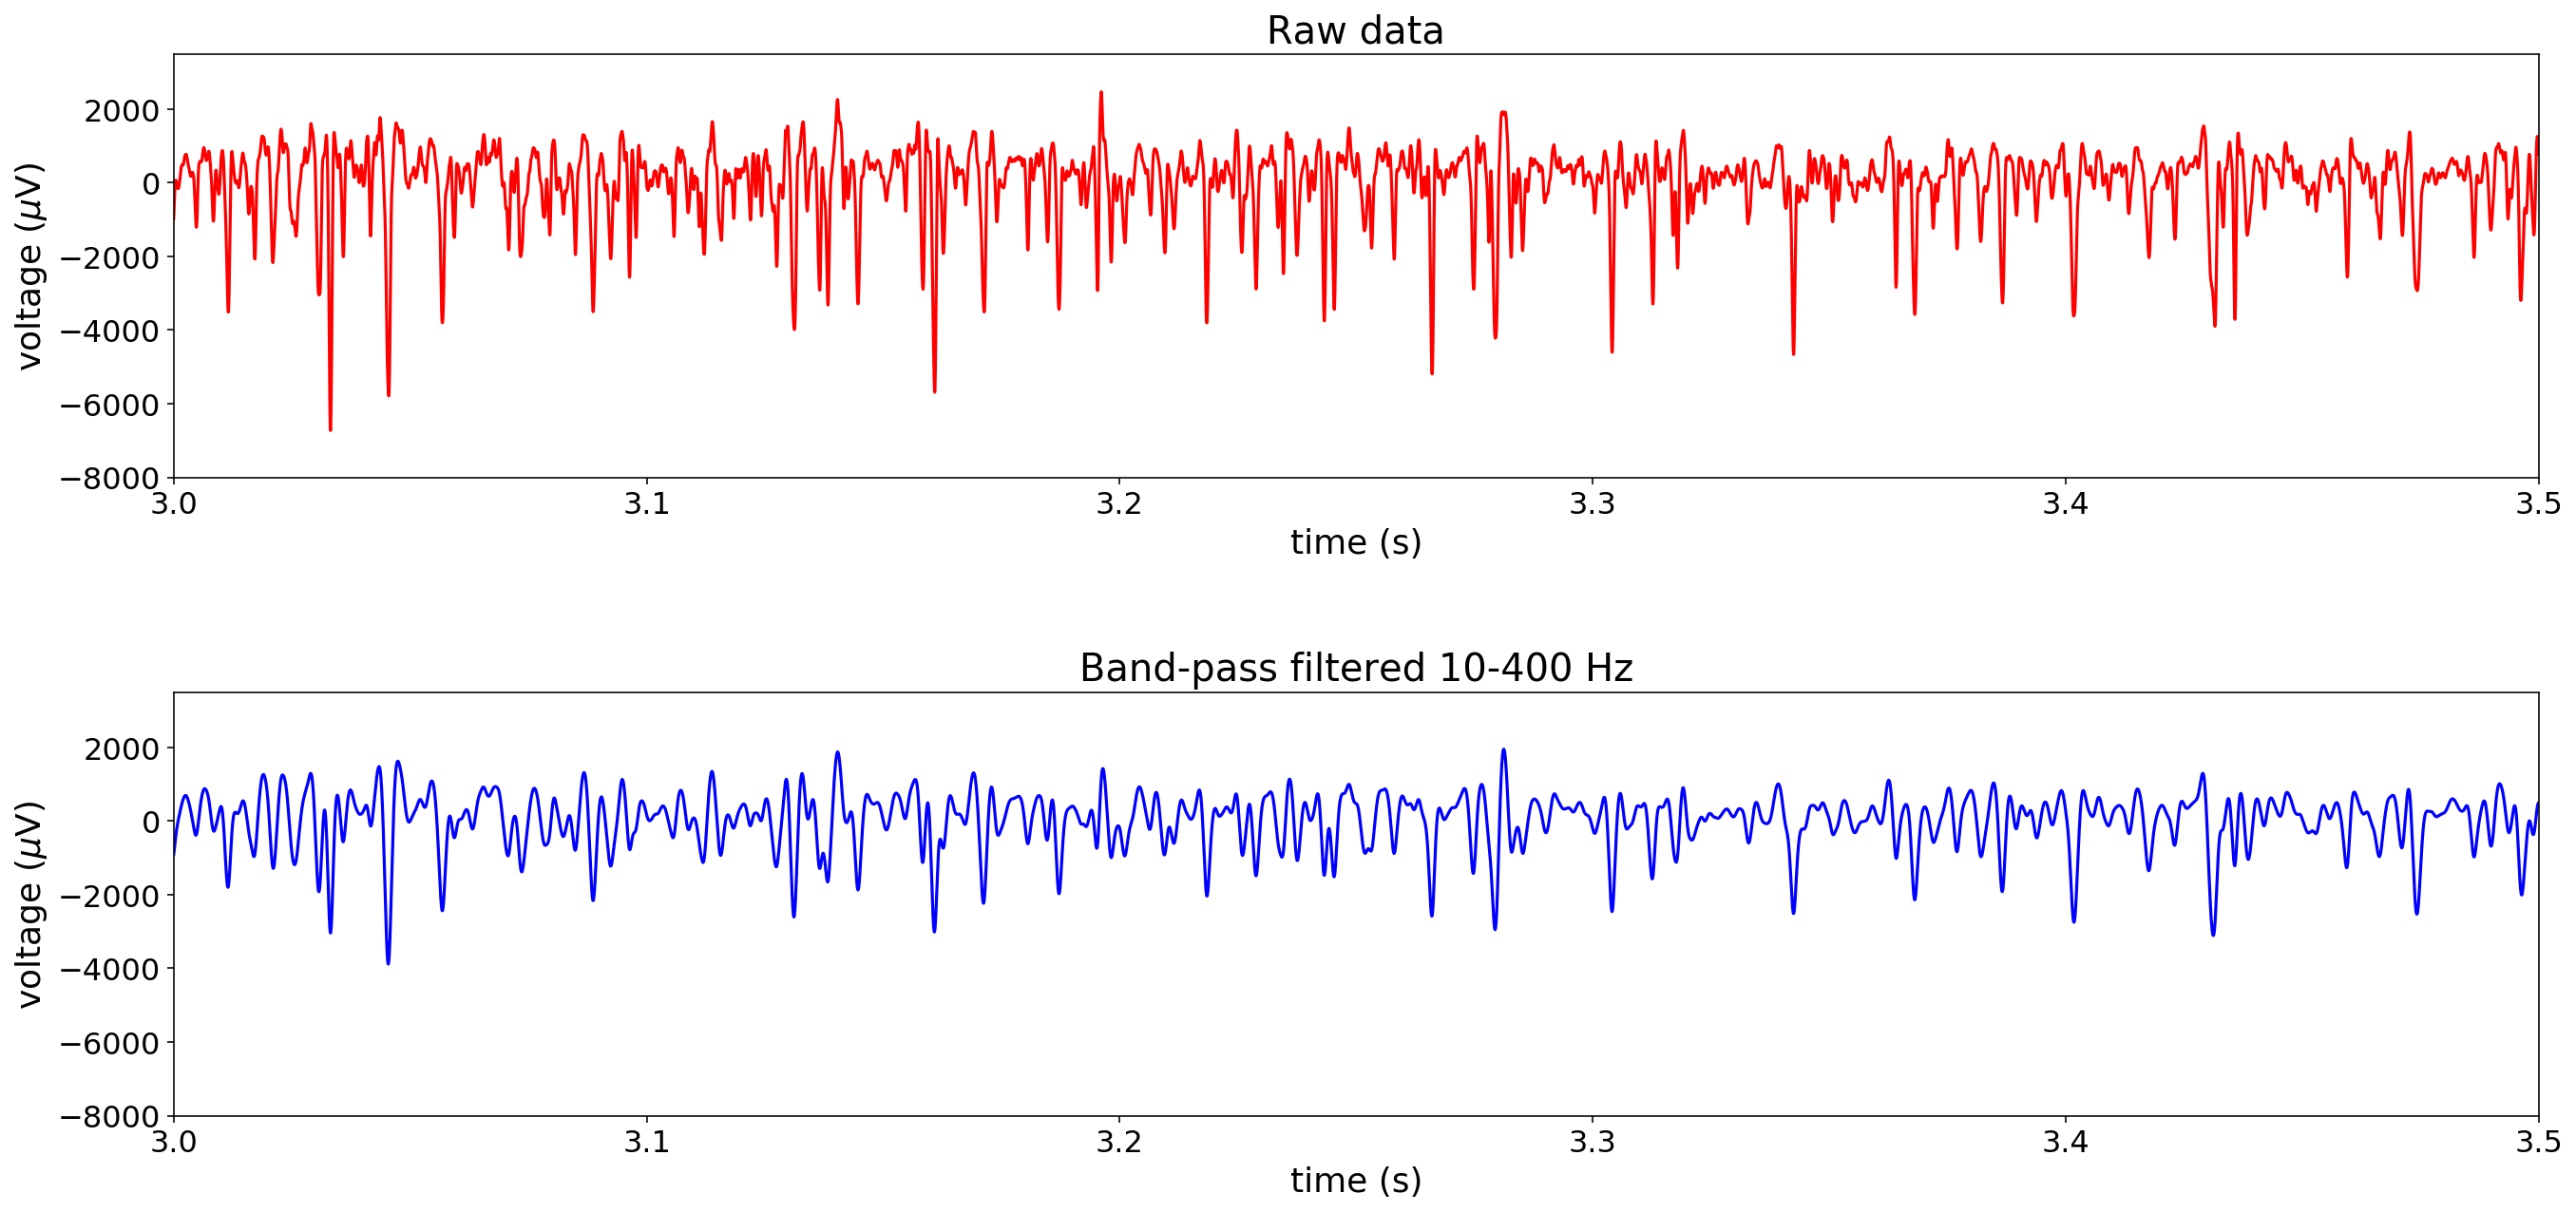

In [127]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex= False, sharey= True, figsize = (20,10))

# plot raw data
ax1.plot(xx['timeEMG'], xx['waveData'], 'r')
ax1.set_title('Raw data', fontsize=20)
ax1.set_xlim(3.0,3.5)
ax1.set_ylim(-8000,3500)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('voltage ($\mu$V)')

# plot filtered data
ax2.plot(xx['timeEMG'], dataf, 'b')
ax2.set_title('Band-pass filtered 10-400 Hz', fontsize=20)
ax2.set_xlim(3.0,3.5)
ax2.set_ylim(-8000,3500)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('voltage ($\mu$V)')

# spacing between subplots
plt.tight_layout(pad=3.0)

### Study questions and exercises:

* Describe the effects of band-pass filtering the EMG signal. 
* Why did we specify the frequency range 10-400 Hz? How is the frequency range to be used related to the physiological signal you are recording?
* What would happen if you changed the frequency band? Experiment with different filter frequency bands. Graph and compare the results.
* The recording we used as an example is clean, with very little noise. Try running the same filter on another recording from the repository which has a lower signal-to-noise ratio.
* Are there other types of filters you could use to remove noise from your recordings? Describe them and their advantages/disadvantages. 

## Processing EMG data

For analysis, it is sometimes easier if we rectify the EMG signal so that we end up with only positive voltage values. This will later make it possible to calculate an envelope and set a threshold for detecting contractions, among other analyses.

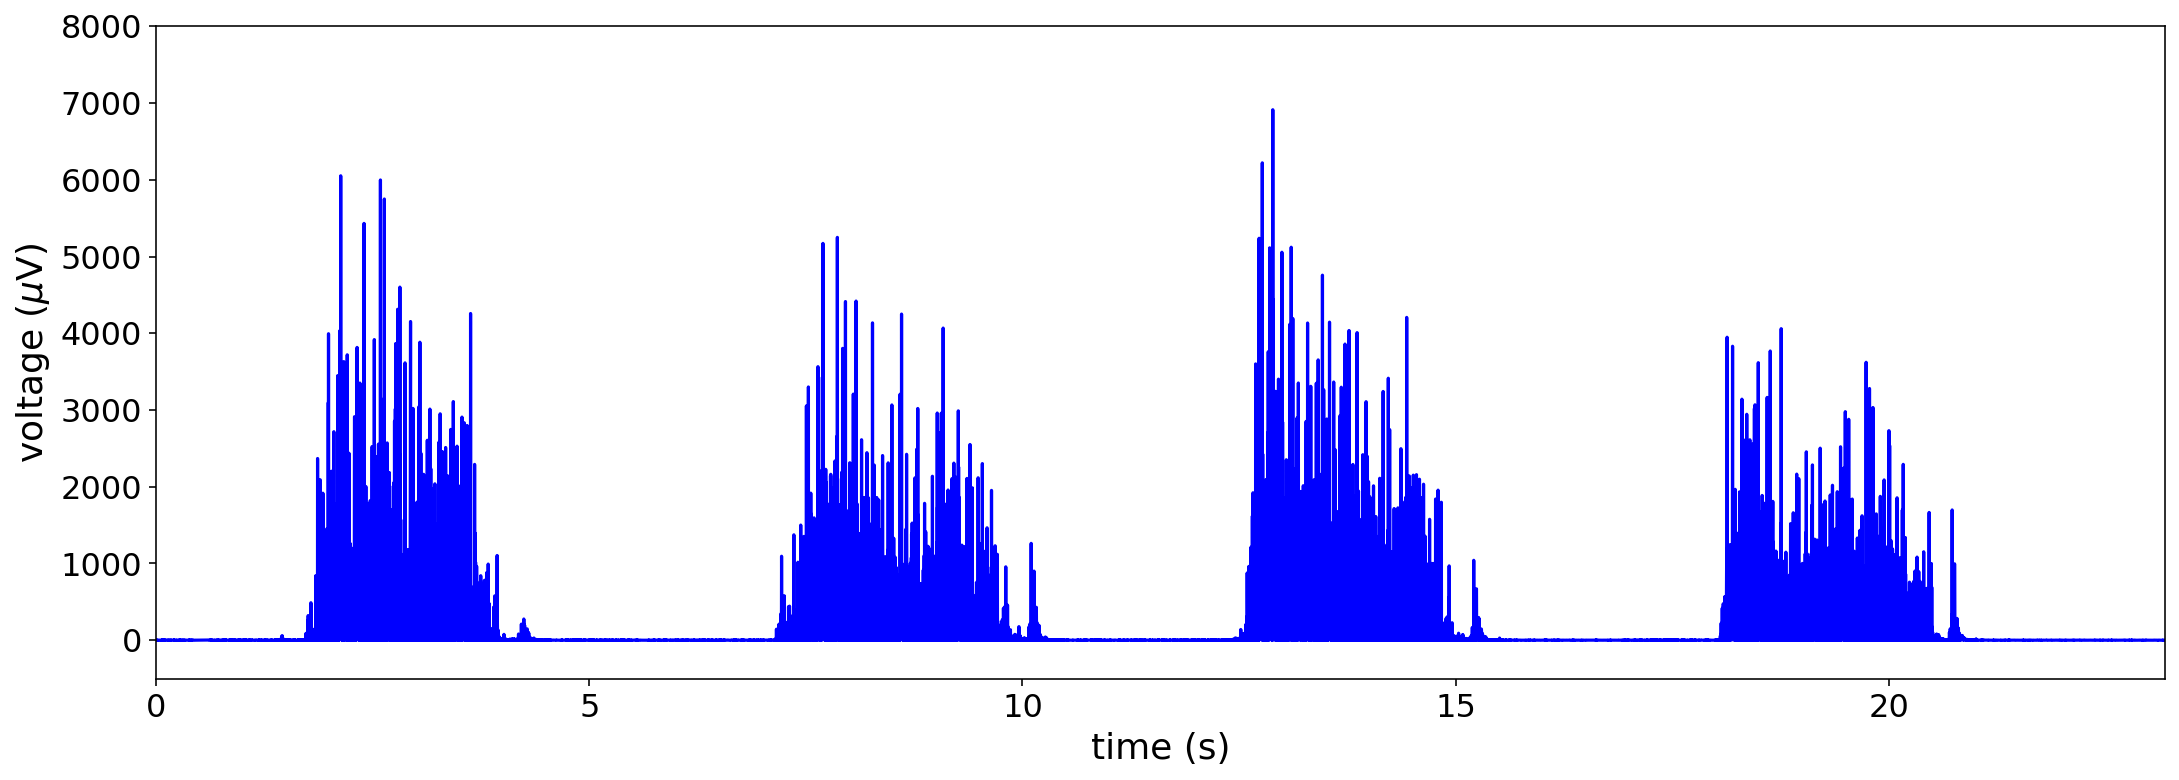

In [74]:
# rectify EMG signal
absSignal = np.absolute(dataf)
timeAbs=np.linspace(0, len(absSignal)/xx['sampleRate'], num=len(absSignal))

# plot rectified data
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(xx['timeEMG'],absSignal,'b')
plt.xlim(0,max(xx['timeEMG']))
plt.ylim(-500,8000)
plt.show()

Next, we can determine the envelope of the rectified signal. One way to do this is to apply a low-pass Butterworth filter, in this case with a cutoff of 8 Hz. 

In [128]:
# low-pass Butterworth filter for envelope detection
lowp = 8
sfreq = xx['sampleRate']
low_pass = lowp/sfreq
b, a = sc.signal.butter(4, low_pass, btype='lowpass')
datafrle = filtfilt(b, a, absSignal)

When we graph the data, we add a degree of transparency to the EMG signal (using the alpha parameter) and superimpose the envelope detection as performed by the low-pass filter. Note that we multiply the envelope signal several times to be able to compare its fit to the original signal.

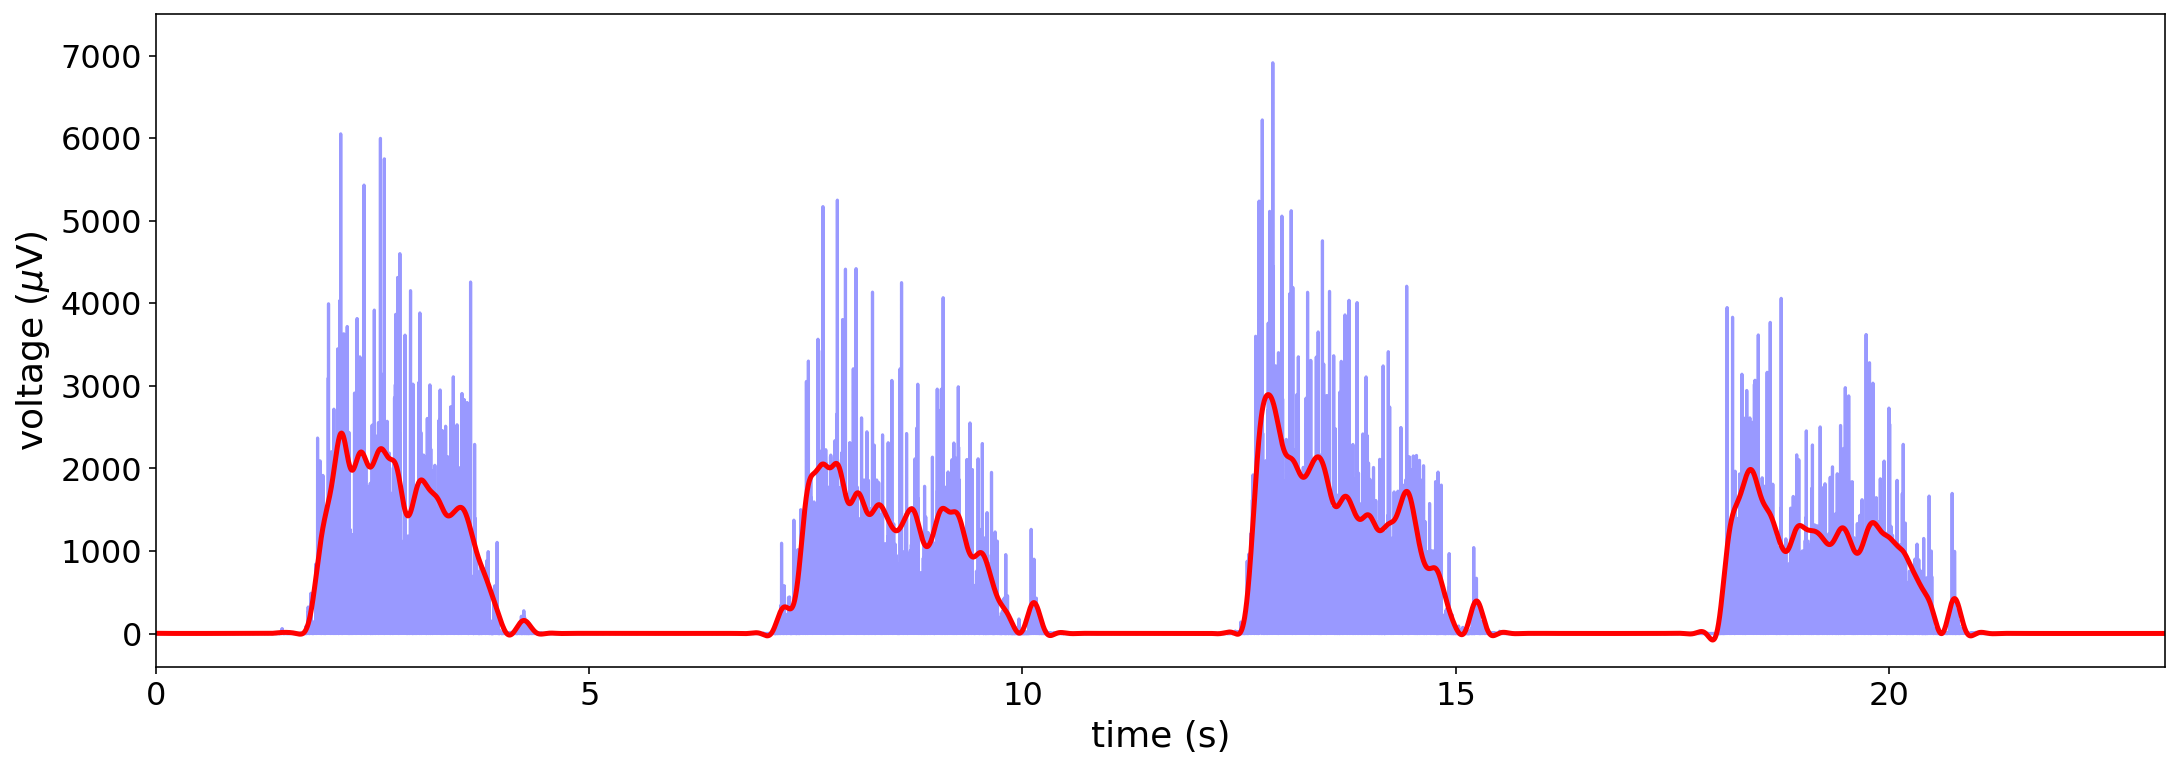

In [129]:
# plot rectified EMG signal with superimposed envelope detection with low-pass filter
plt.figure(figsize=(18,6))
plt.xlabel('time (s)')
plt.ylabel('voltage ($\mu$V)')
plt.plot(timeAbs,absSignal, 'b', alpha=0.4)
plt.plot(timeAbs,datafrle*3, 'r', linewidth=2.5) # multiply envelope to see data fit
plt.xlim(0,max(xx['timeEMG']))
plt.ylim(-400,7500);

### Study questions and exercises:

* Describe the effects of low-pass filtering the EMG signal. 
* Why did we specify 8 Hz as the low-pass cutoff? 
* What would happen if you changed the cutoff? Experiment with different cutoffs. Graph and compare the results.
* Are there other techniques you could use to calculate the envelope of the rectified EMG signal? Describe them and their advantages/disadvantages. Apply at least one of these techniques and graph the results.

## Analyzing the data
When analyzing muscle activity, it is useful to know the start and stop times of the contractions. With this information, for example, we can quantify the contraction durations and see how much these vary over a recording. In other words, is the subject able to maintain contractions of the same duration, or do the contractions get shorter over the course of the recording? Or, we can quantify how long a subject is able to maintain a sustained contraction, and then quantify how this changes over repeated trials. Both of these quantifications could allow us to look at how particular exercises induce muscle fatigue. 

### Detecting start and stop times of muscle contraction

If we plot just the EMG envelope (not the multiplied signal superimposed on the rectified EMG), we can then estimate the best value to use as a threshold to detect muscle contraction start and stop times. We want a value low enough to include the majority of the contraction, but large enough to exclude noise and small muscle twitches. For the envelope plotted below, it looks like 200 (dashed line) is a good candidate threshold. 

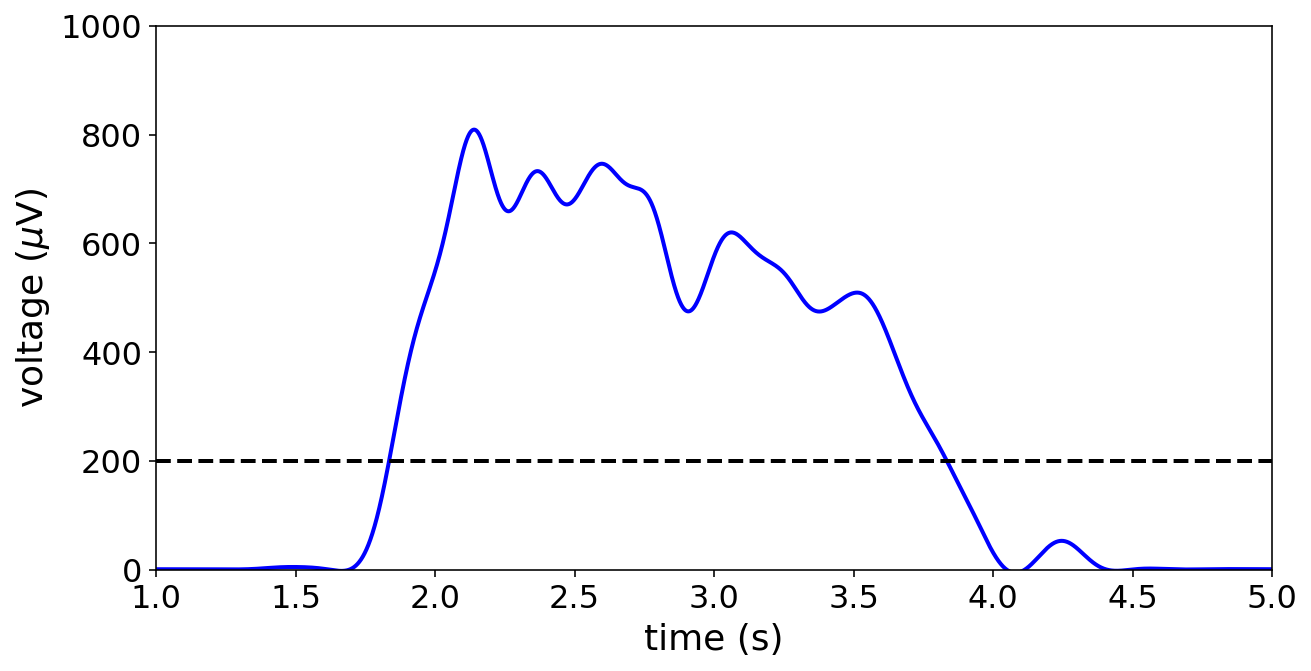

In [136]:
# plot just the envelope to determine threshold for detecting contractions
plt.figure(figsize=(10,5))
plt.xlabel('time (s)')
plt.ylabel('voltage ($\mu$V)')
plt.plot(timeAbs,datafrle, 'b', linewidth=2.0)
plt.axhline(y=200, color='k',linewidth=2.0, linestyle='--') # potential threshold 
plt.xlim(1,5)
plt.ylim(0,1000);

We can then use our threshold to detect the contraction start and stop times. For the start times, we want the indices where the signal value is equal to or greater than the threshold when the previous value was below the threshold, i.e. the ascending threshold crossing. 

In [133]:
threshold = 200
cstarts = []
for i in range(1, len(datafrle)):
    if datafrle[i-1] < threshold and datafrle[i] >= threshold:
        cstarts.append(i)
        
print(cstarts) 

[80940, 326408, 556036, 797722]


For the stop times, we want the indices where the signal value is below the threshold when the previous value was equal to or above the threshold, i.e. the descending threshold crossing. 

In [134]:
threshold = 200
cstops = []
for i in range(1, len(datafrle)):
    if datafrle[i-1] >= threshold and datafrle[i] < threshold:
        cstops.append(i)
        
print(cstops)

[169099, 425989, 654532, 897724]


We then divide the start and stop times by the sampling rate to get the times in seconds. 

In [135]:
starts=[]
for n in range(0, len(cstarts)):
    starttime = cstarts[n]/xx['sampleRate']
    starts.append(starttime)
    
print(starts)

stops=[]
for n in range(0, len(cstops)):
    stoptime = cstops[n]/xx['sampleRate']
    stops.append(stoptime)
    
print(stops)

[1.835374149659864, 7.401541950113379, 12.608526077097507, 18.08893424036281]
[3.8344444444444443, 9.659614512471656, 14.841995464852607, 20.35655328798186]


To see how well our event detection works, we plot the enveloped EMG signal and then plot the start and stop times with dashed lines. We can go back and adjust the threshold depending on whether we want to capture more or less of the muscle activity. 

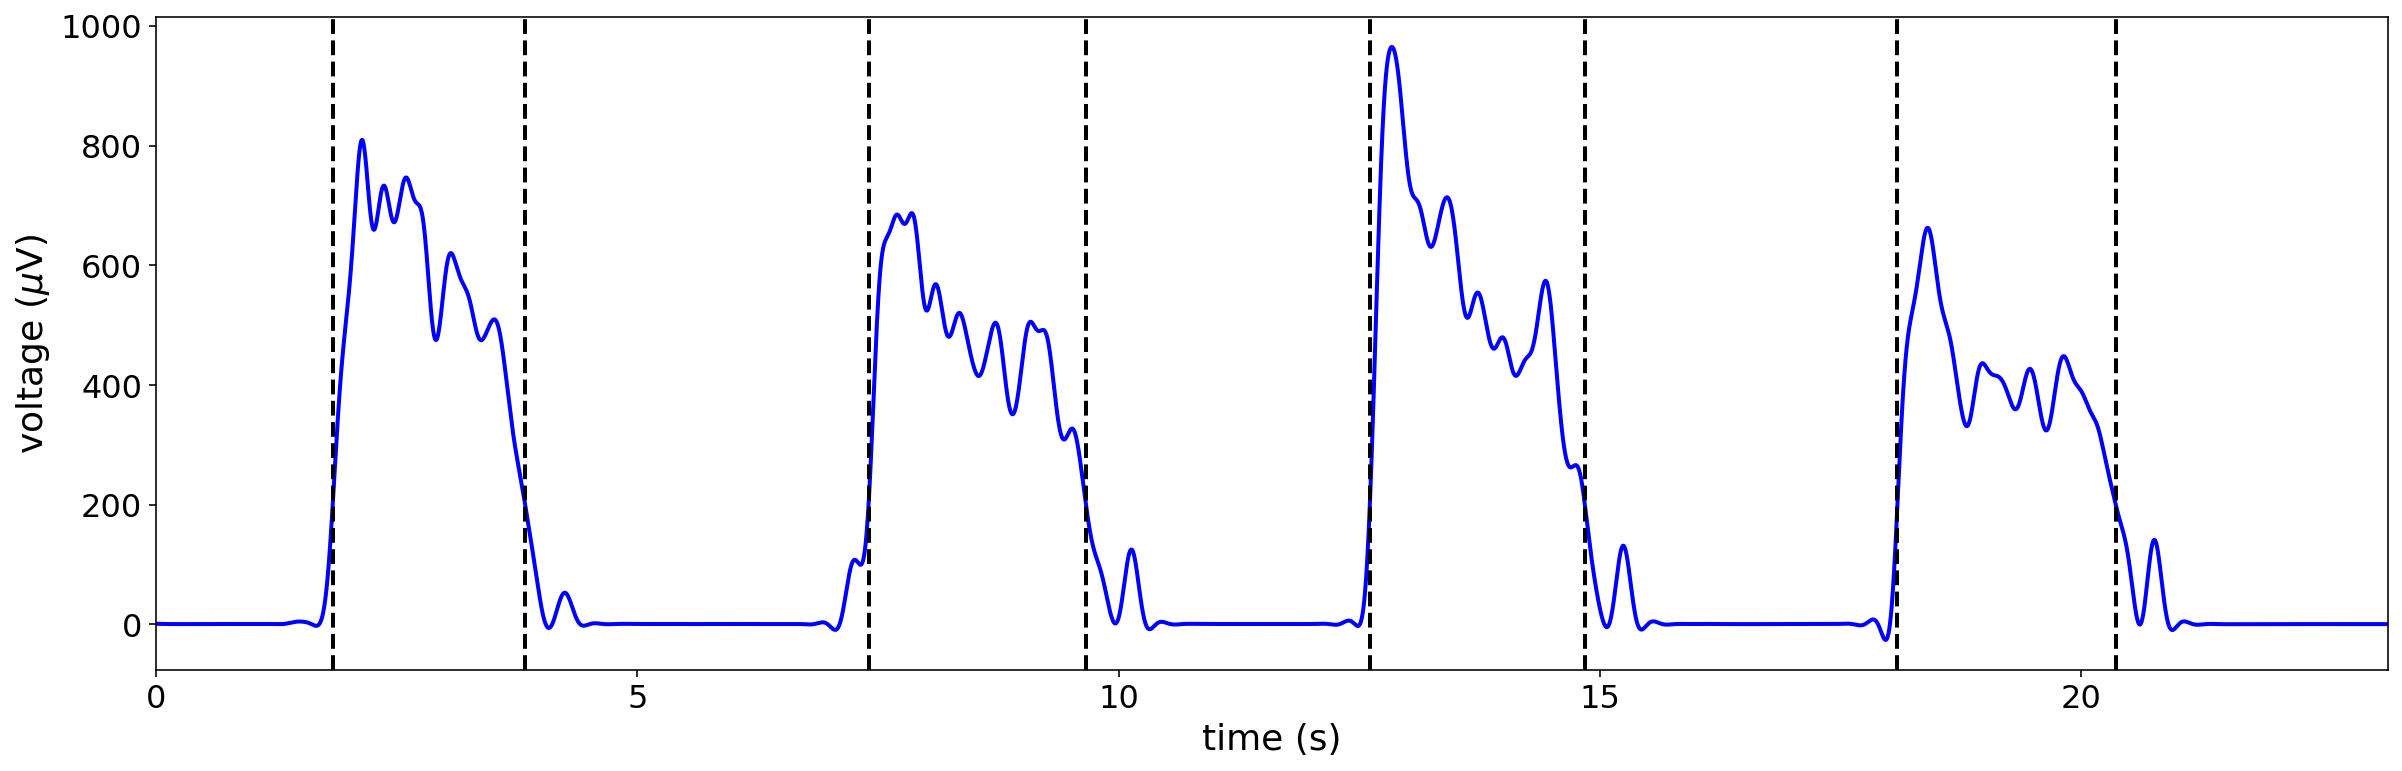

In [137]:
# plot envelope with contraction start and stop times marked by dashed lines
plt.figure(figsize=(20,6))
plt.xlabel('time (s)')
plt.ylabel('voltage ($\mu$V)')
plt.plot(timeAbs, datafrle, 'b', linewidth=2.0)      
for n in range(0, len(starts)):
    plt.axvline(x=starts[n], color='k',linewidth=2.0, linestyle='--')
for n in range(0, len(stops)):
    plt.axvline(x=stops[n], color='k',linewidth=2.0, linestyle='--')
plt.xlim(0, max(xx['timeEMG']));

We can see from the above figure that our contraction detection works well. With the selected threshold, we are detecting the start and stop times of the principle contractions, while excluding the small muscle twitches following each. We can adjust the threshold if needed to improve the detection. Remember also that the threshold will have to be determined for each recording. 

Now, by taking the difference between the successive start and stop times, we can calculate the duration of each muscle contraction. We print the durations rounded up to two decimal places. Units are in seconds.

In [138]:
# calculate and print the contraction durations in seconds
durs=[]
for n in range(0,len(starts)):
    durs.append(stops[n]-starts[n])
    print(round(durs[n], 2))

2.0
2.26
2.23
2.27


### Study questions and exercises:

* Decrease/increase the threshold, plot the results, and describe what happens to contraction detection.
* What are the disadvantages of the technique we used to detect contraction start and stop times? 
* Are there other techniques you could use to detect the start and stop times? If so, what are they? How would you implement them?
* Write and implement code that will allow you to quantify other aspects of the muscle activity, such as the rest interval between each contraction.

## Analyzing more recordings

To analyze more recordings, we first define a function that will allow us to quickly run the basic data extraction, visualization, and signal processing. This way we can easily look at different recordings just by changing the file name, or even batch run multiple files using a simple for loop. This function includes many of the same commands we had in our previous function, but now we add in the filtering, signal rectification, and envelope detection. An additional input to the function also allows us to specify whether we want to graph the data or just run the function without graphing.

In [239]:
def processEMG(file,graph):
    # open .wav file by specifying the path and filename
    record = wave.open(file)
    # extract number of channels, sample rate, data
    numChannels = record.getnchannels() # number of channels
    N = record.getnframes() # humber of frames
    sampleRate = record.getframerate() # sampling rate
    # extract data from the .wav file
    dstr = record.readframes(N * numChannels)
    waveData = np.frombuffer(dstr, np.int16)
    # calculate time window
    timeEMG=np.linspace(0, len(waveData)/sampleRate, num=len(waveData))
    # calculate frequency
    freq = 1/np.mean(np.diff(timeEMG))
    # band-pass Butterworth filter at 10-400Hz
    b, a = butter(2, ([10, 400]/(freq/2)), btype = 'bandpass')
    dataf = filtfilt(b, a, waveData)
    # rectify filtered EMG signal
    absSignal = np.absolute(dataf)
    timeAbs=np.linspace(0, len(absSignal)/sampleRate, num=len(absSignal))
    # low-pass Butterworth filter for envelope detection
    lowp = 8
    sfreq = sampleRate
    low_pass = lowp/sfreq
    b, a = sc.signal.butter(4, low_pass, btype='lowpass')
    datafrle = filtfilt(b, a, absSignal)
    # save relevant data in array
    xx={'sampleRate':sampleRate,\
        'waveData':waveData,\
        'timeEMG':timeEMG,\
        'freq':freq,\
        'dataf':dataf,\
        'absSignal':absSignal,\
        'timeAbs':timeAbs,\
        'datafrle':datafrle       
        }   
    # plot EMG 
    if graph:
        
        fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (20,15))

        # plot filtered data
        ax1.plot(timeEMG,dataf, 'b')
        ax1.set_title('Raw data', fontsize=20)
        ax1.set_xlim(0,max(timeEMG))
        #ax1.set_ylim(-8000,4000)
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('voltage ($\mu$V)')
        
        # plot rectified data with envelope
        ax2.plot(timeAbs,datafrle*3, 'r', linewidth=2.5) # multiply envelope to see data fit
        ax2.plot(timeAbs,absSignal, 'b', alpha=0.4)
        ax2.set_title('Rectified EMG with envelope', fontsize=20)
        ax2.set_xlim(0,max(timeEMG))
        ax2.set_xlabel('time (s)')
        ax2.set_ylabel('voltage ($\mu$V)')
        
        # plot envelope with potential threshold
        ax3.plot(timeAbs,datafrle, 'b')
        #plt.axhline(y=200, color='k',linewidth=2.0, linestyle='--') # potential threshold 
        ax3.set_title('Envelope with potential threshold', fontsize=20)
        ax3.set_xlim(0,max(timeEMG))
        #ax3.set_ylim(0,1200)
        ax3.set_xlabel('time (s)')

        # spacing between subplots
        plt.tight_layout(pad=3.0)
    
    return xx

Now we can run the function on a different file. The following EMG was recorded from the bicep muscle during repeated contractions.

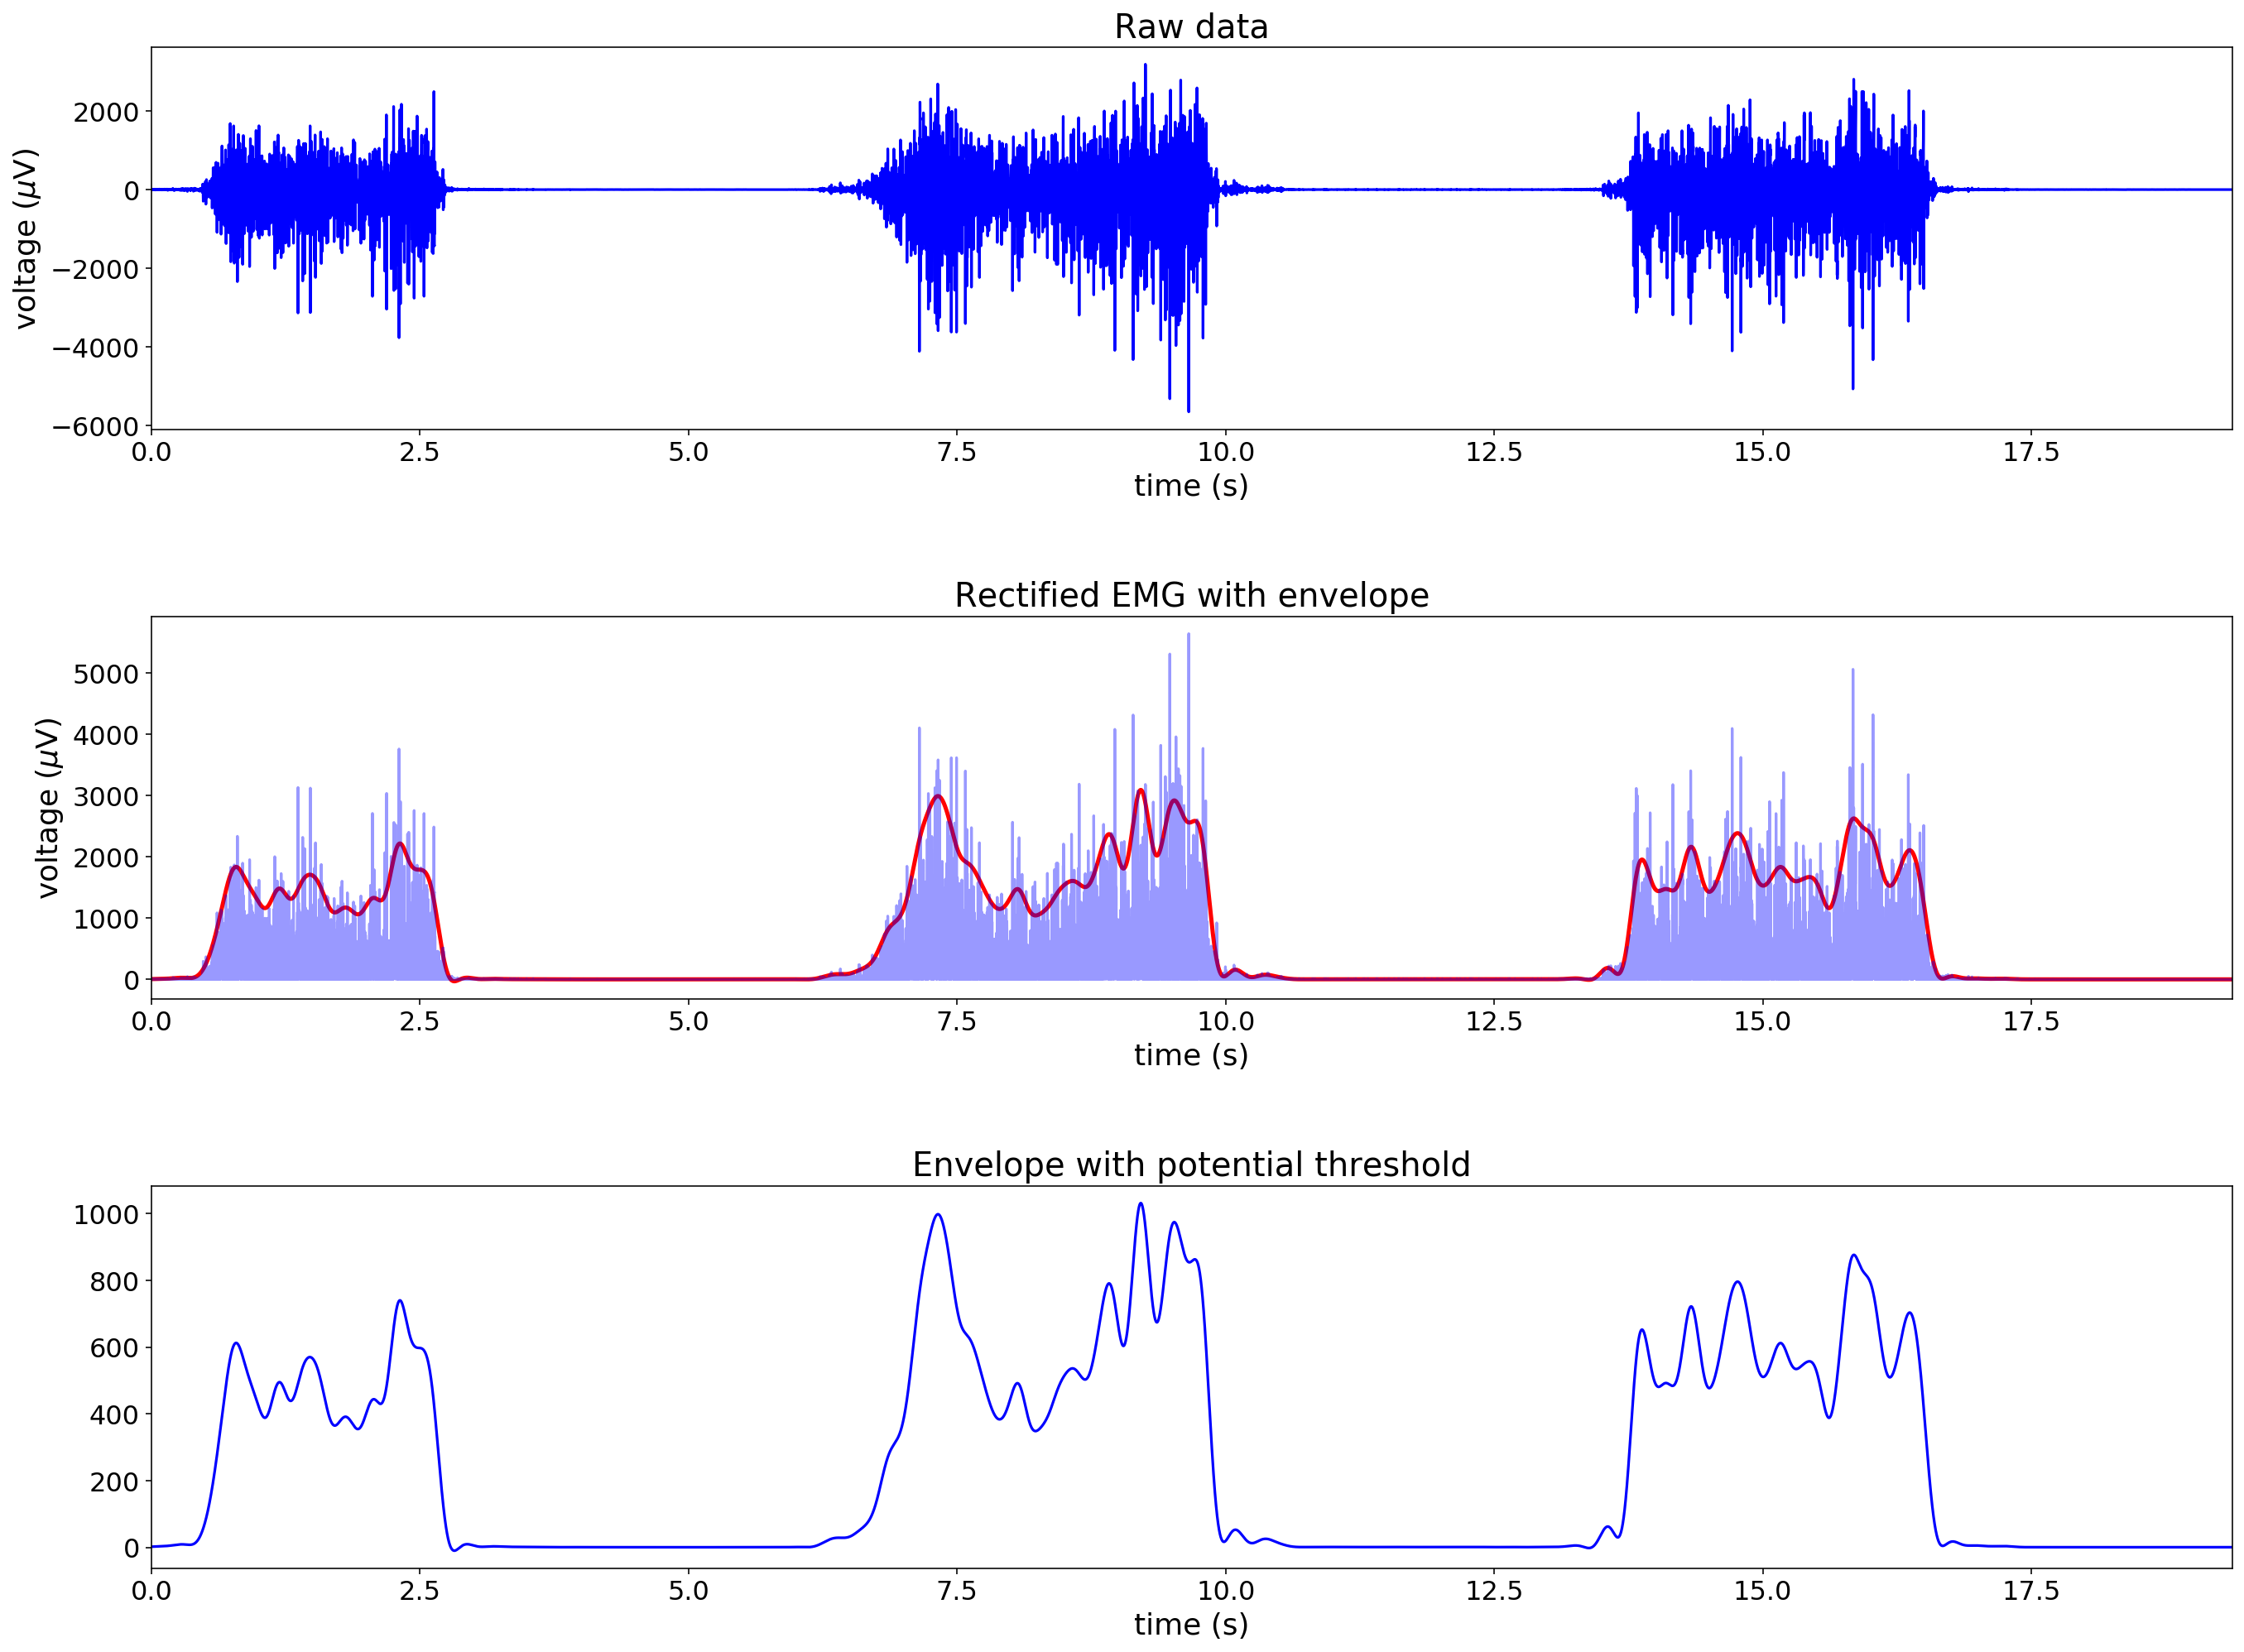

In [240]:
xx=processEMG(file='../data/S10_EMG_bicep_intermittent.wav',graph=1)

In [241]:
def contractions(threshold):
    
    # ascending threshold crossings
    cstarts = []
    for i in range(1, len(xx['datafrle'])):
        if xx['datafrle'][i-1] < threshold and xx['datafrle'][i] >= threshold:
            cstarts.append(i)
    
    # descending threshold crossings
    cstops = []
    for i in range(1, len(xx['datafrle'])):
        if xx['datafrle'][i-1] >= threshold and xx['datafrle'][i] < threshold:
            cstops.append(i)
    
    # divide start and stop times by the sampling rate to get times in seconds
    starts=[]
    for n in range(0, len(cstarts)):
        starttime = cstarts[n]/xx['sampleRate']
        starts.append(starttime)

    stops=[]
    for n in range(0, len(cstops)):
        stoptime = cstops[n]/xx['sampleRate']
        stops.append(stoptime)
    
    # plot envelope with contraction start and stop times marked by dashed lines
    plt.figure(figsize=(20,6))
    plt.xlabel('time (s)')
    plt.ylabel('voltage ($\mu$V)')
    plt.plot(xx['timeAbs'], xx['datafrle'], 'b', linewidth=2.0)      
    for n in range(0, len(starts)):
        plt.axvline(x=starts[n], color='k',linewidth=2.0, linestyle='--')
    for n in range(0, len(stops)):
        plt.axvline(x=stops[n], color='k',linewidth=2.0, linestyle='--')
    plt.xlim(0, max(xx['timeEMG']))
    
    # calculate contraction durations
    durs=[]
    for n in range(0,len(starts)):
        durs.append(stops[n]-starts[n])
        print('Contraction lasted %g seconds'%(round(durs[n], 2)))
        
    return

Contraction lasted 2.12 seconds
Contraction lasted 3.09 seconds
Contraction lasted 2.81 seconds


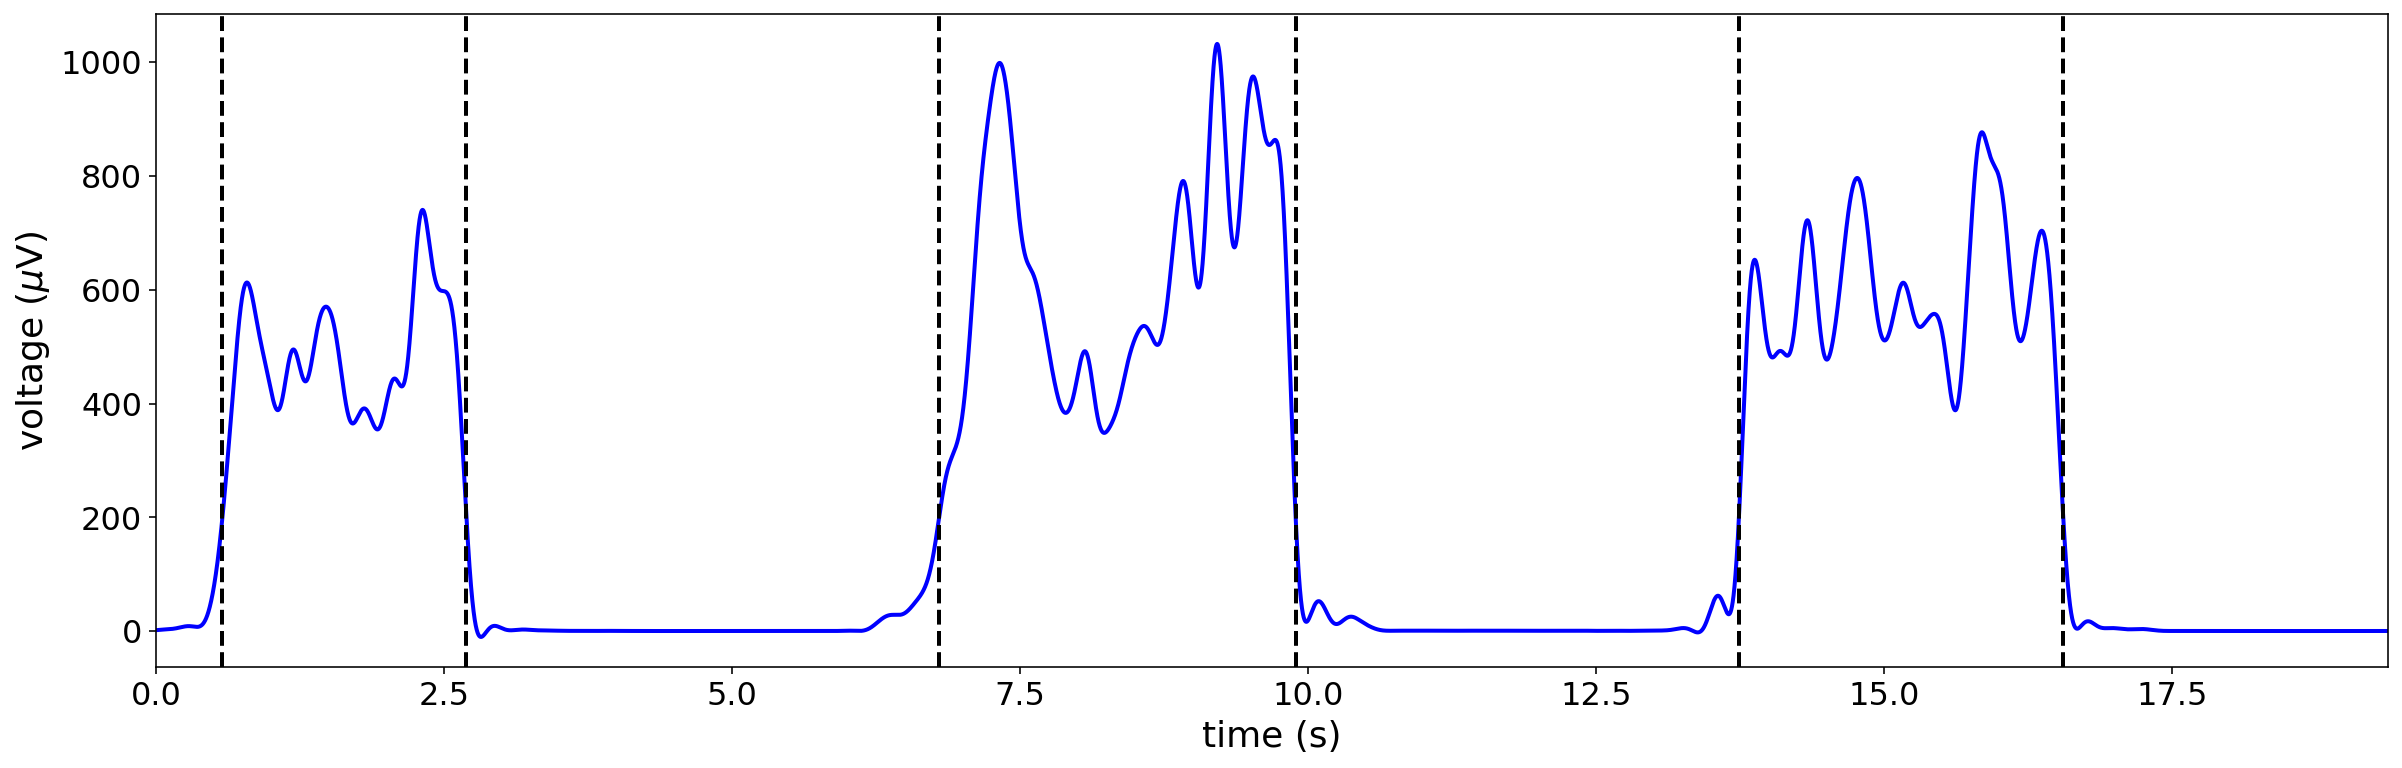

In [242]:
contractions(threshold=200)

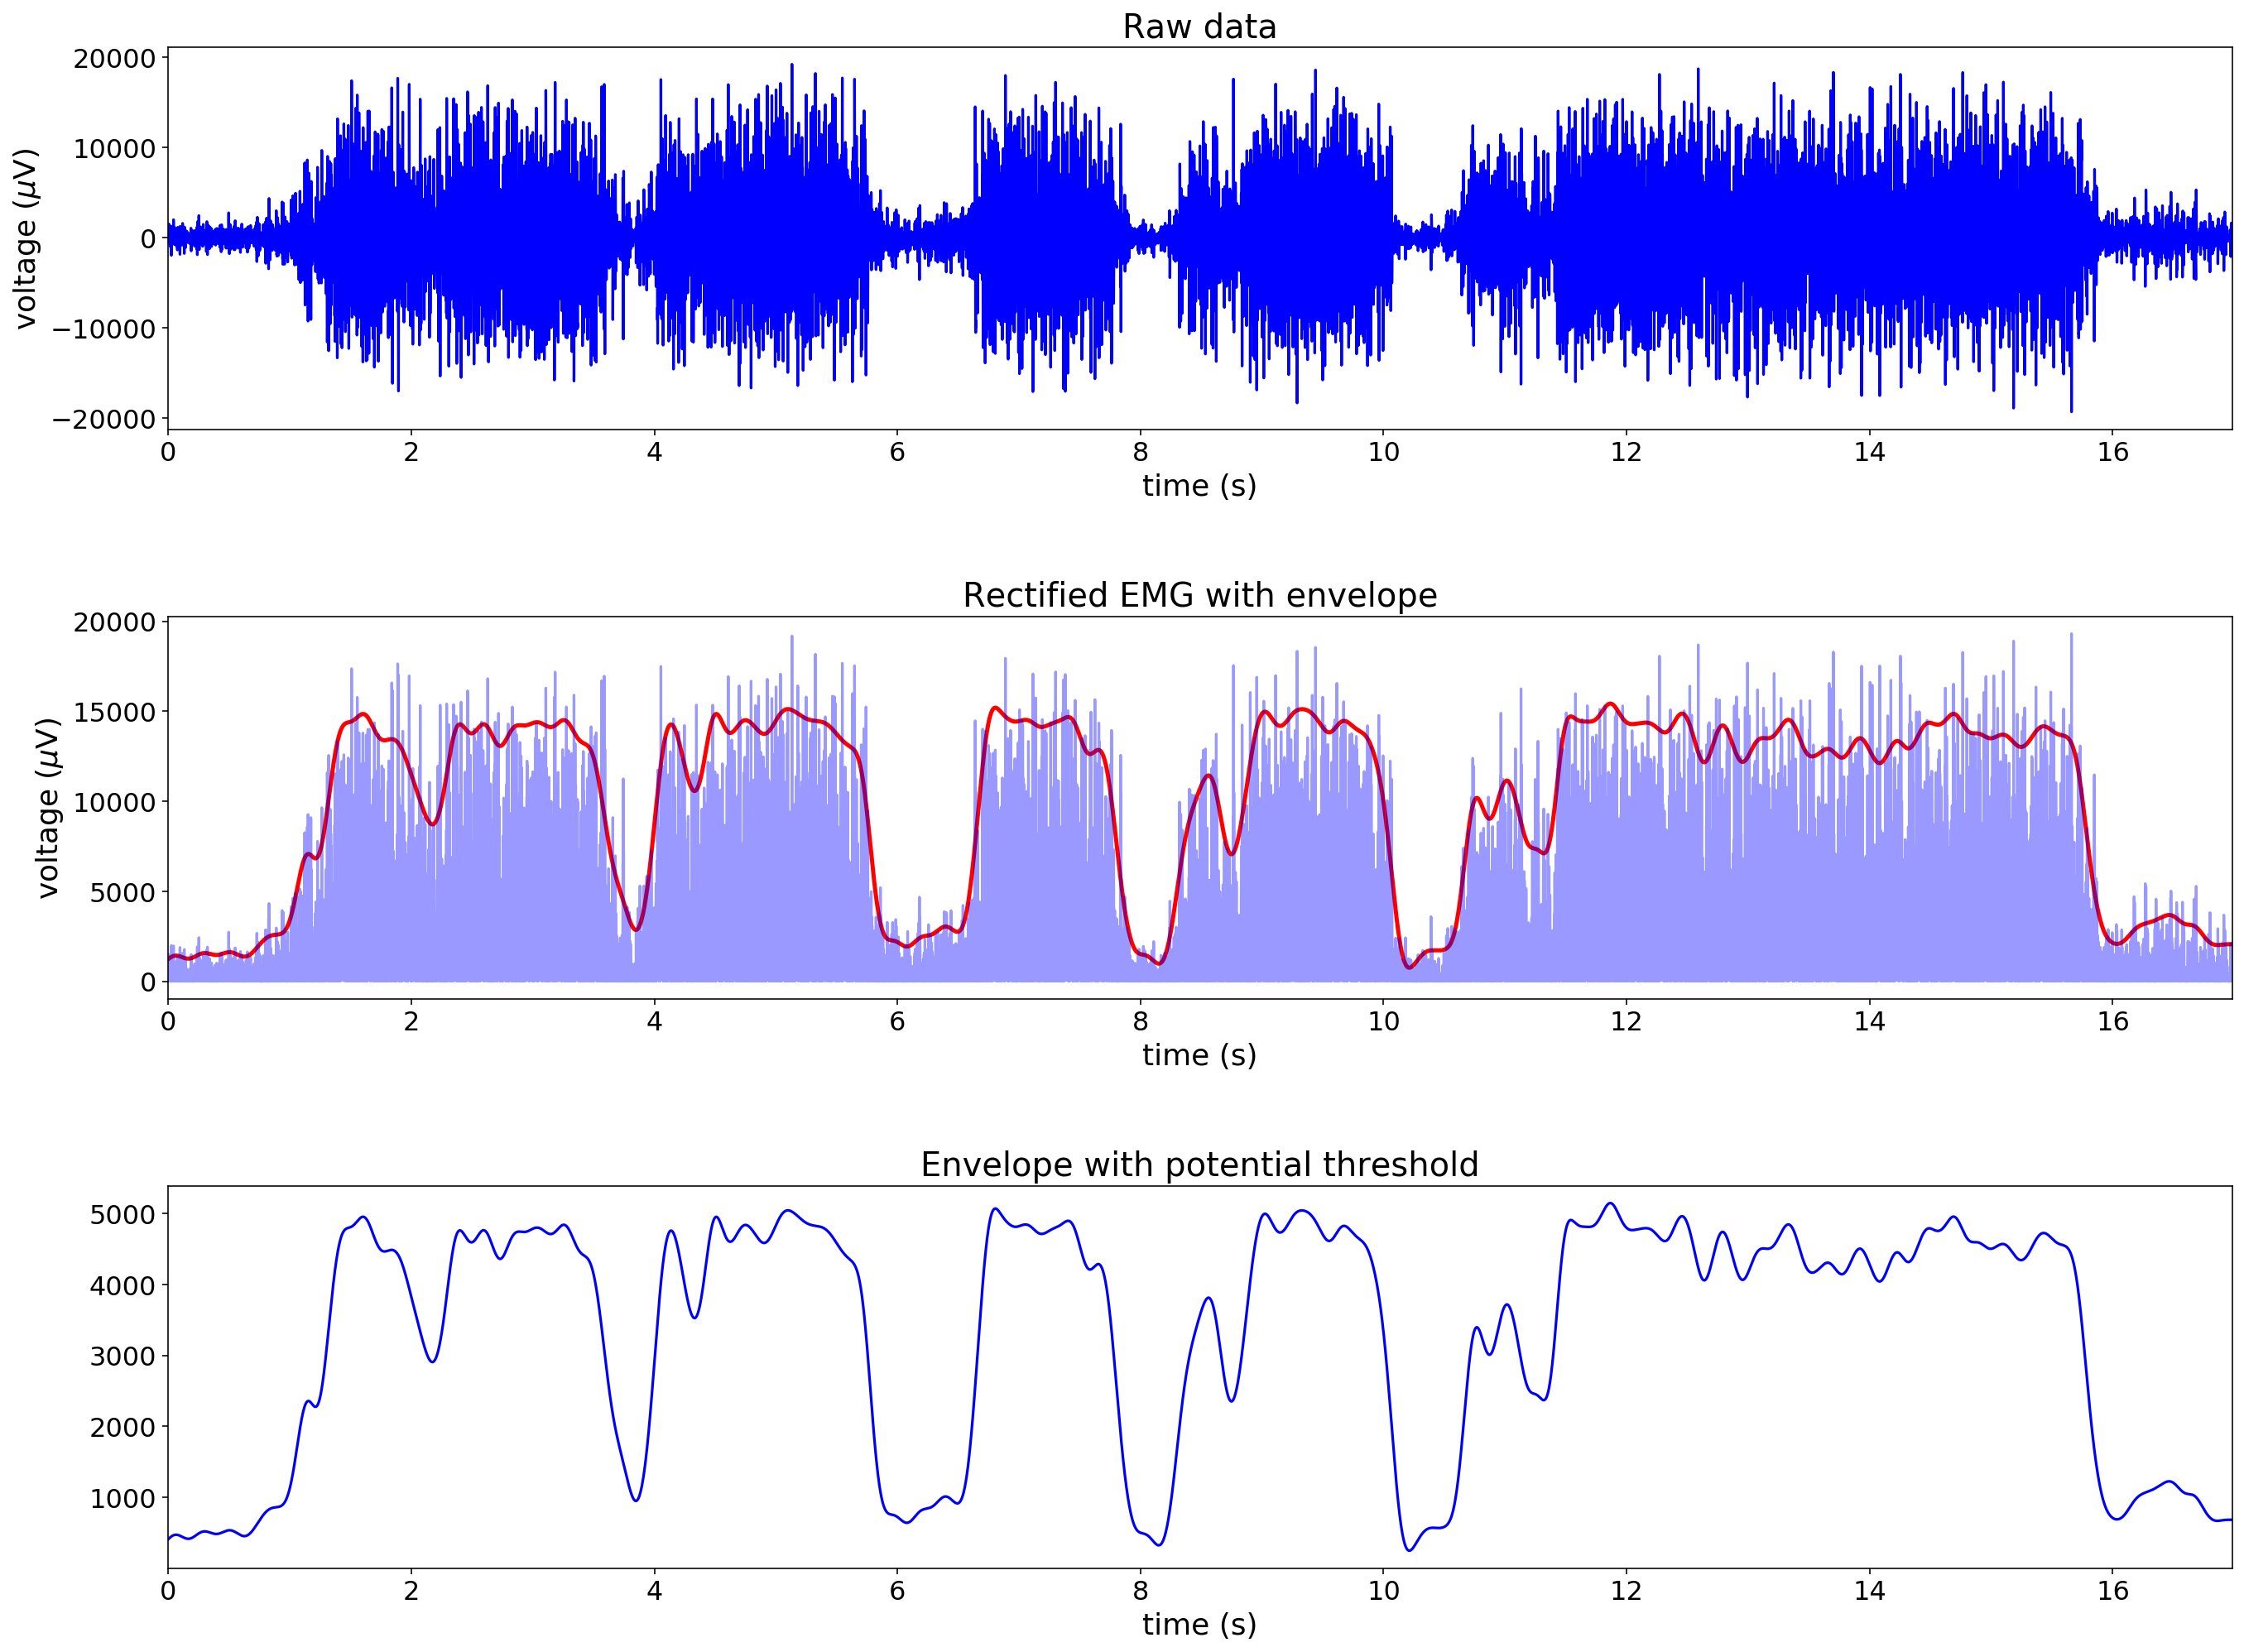

In [243]:
xx=processEMG(file='../data/S2_EMG_forearm_grip.wav',graph=1)

Contraction lasted 2.72 seconds
Contraction lasted 1.92 seconds
Contraction lasted 1.29 seconds
Contraction lasted 1.81 seconds
Contraction lasted 5.25 seconds


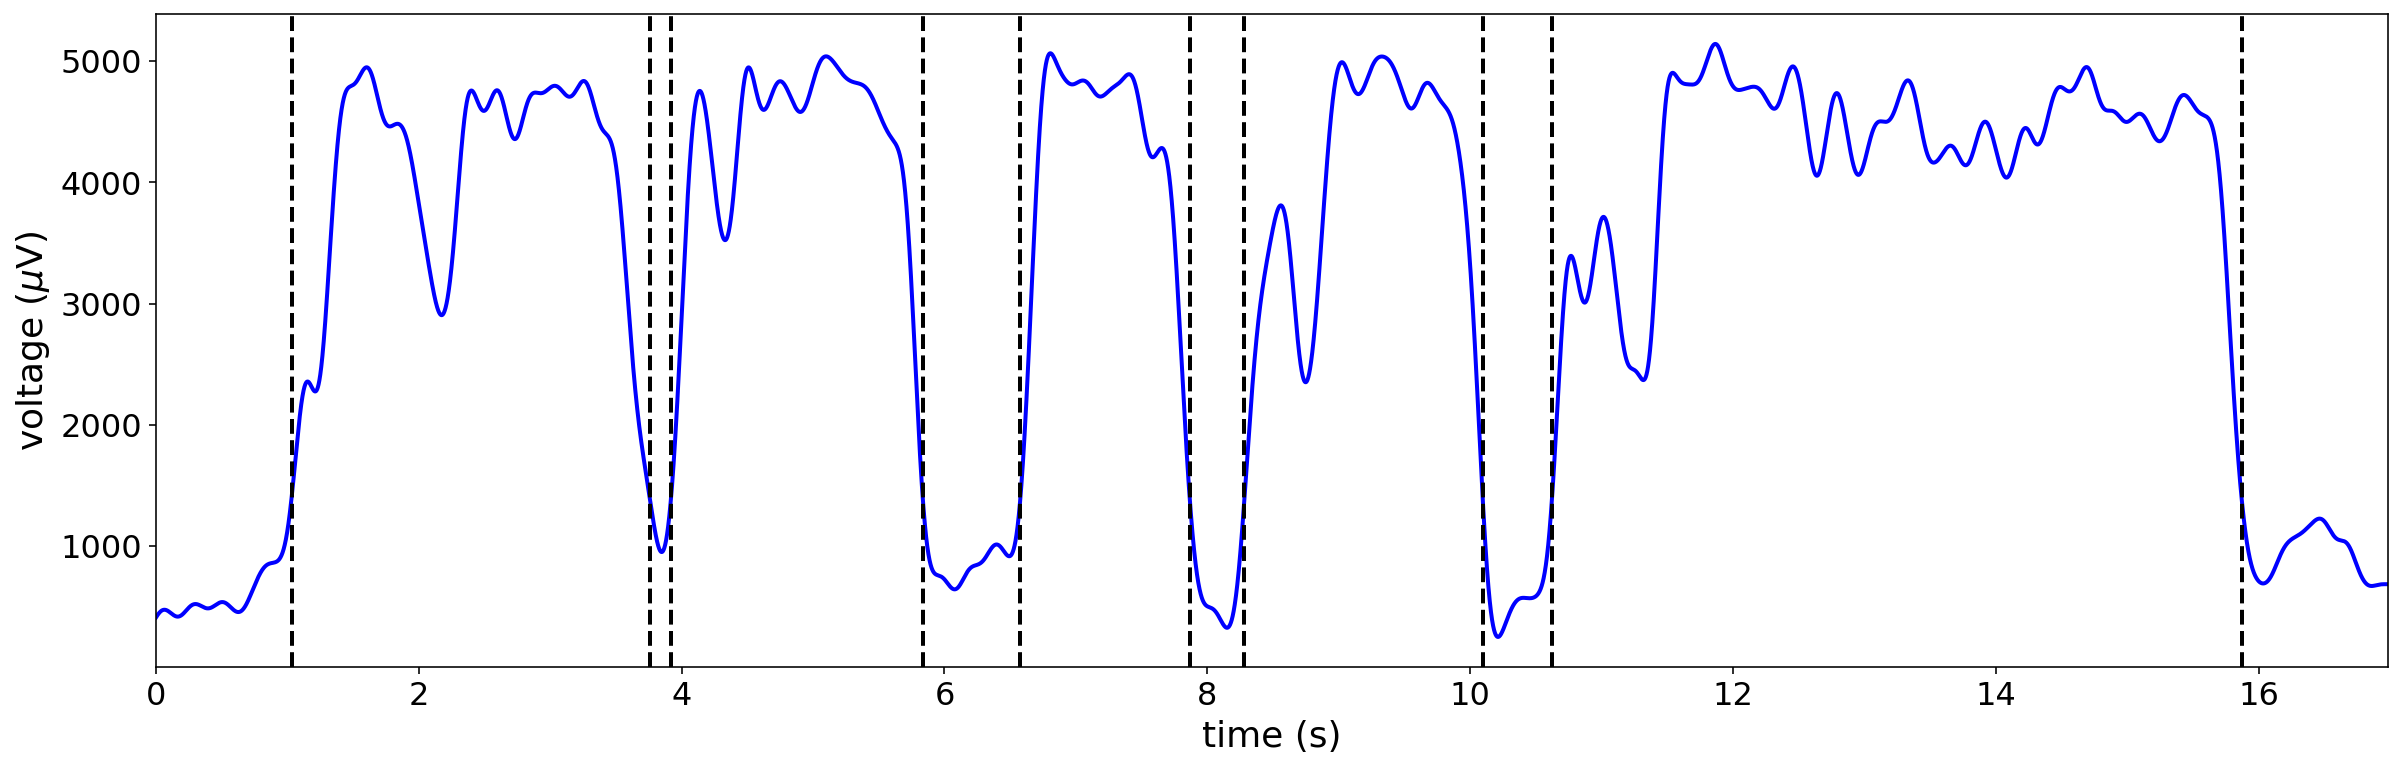

In [245]:
contractions(threshold=1400)

### Muscle fatigue

As muscles contract, they also fatigue, especially if a significant force is used or if the contraction is prolonged. Fatigue can be seen within a single EMG recording during sustained contraction, or across EMG recordings with repeated contractions. There are several ways we can visualize and quantify fatigue. 

#### Muscle fatigue during a single trial
The following recording was obtained from the bicep muscle while performing a sustained concentric contraction, i.e. holding a weight with the arm bent at 90 degrees for 50 seconds (contraction starts around t=5s and ends at t=55s). 

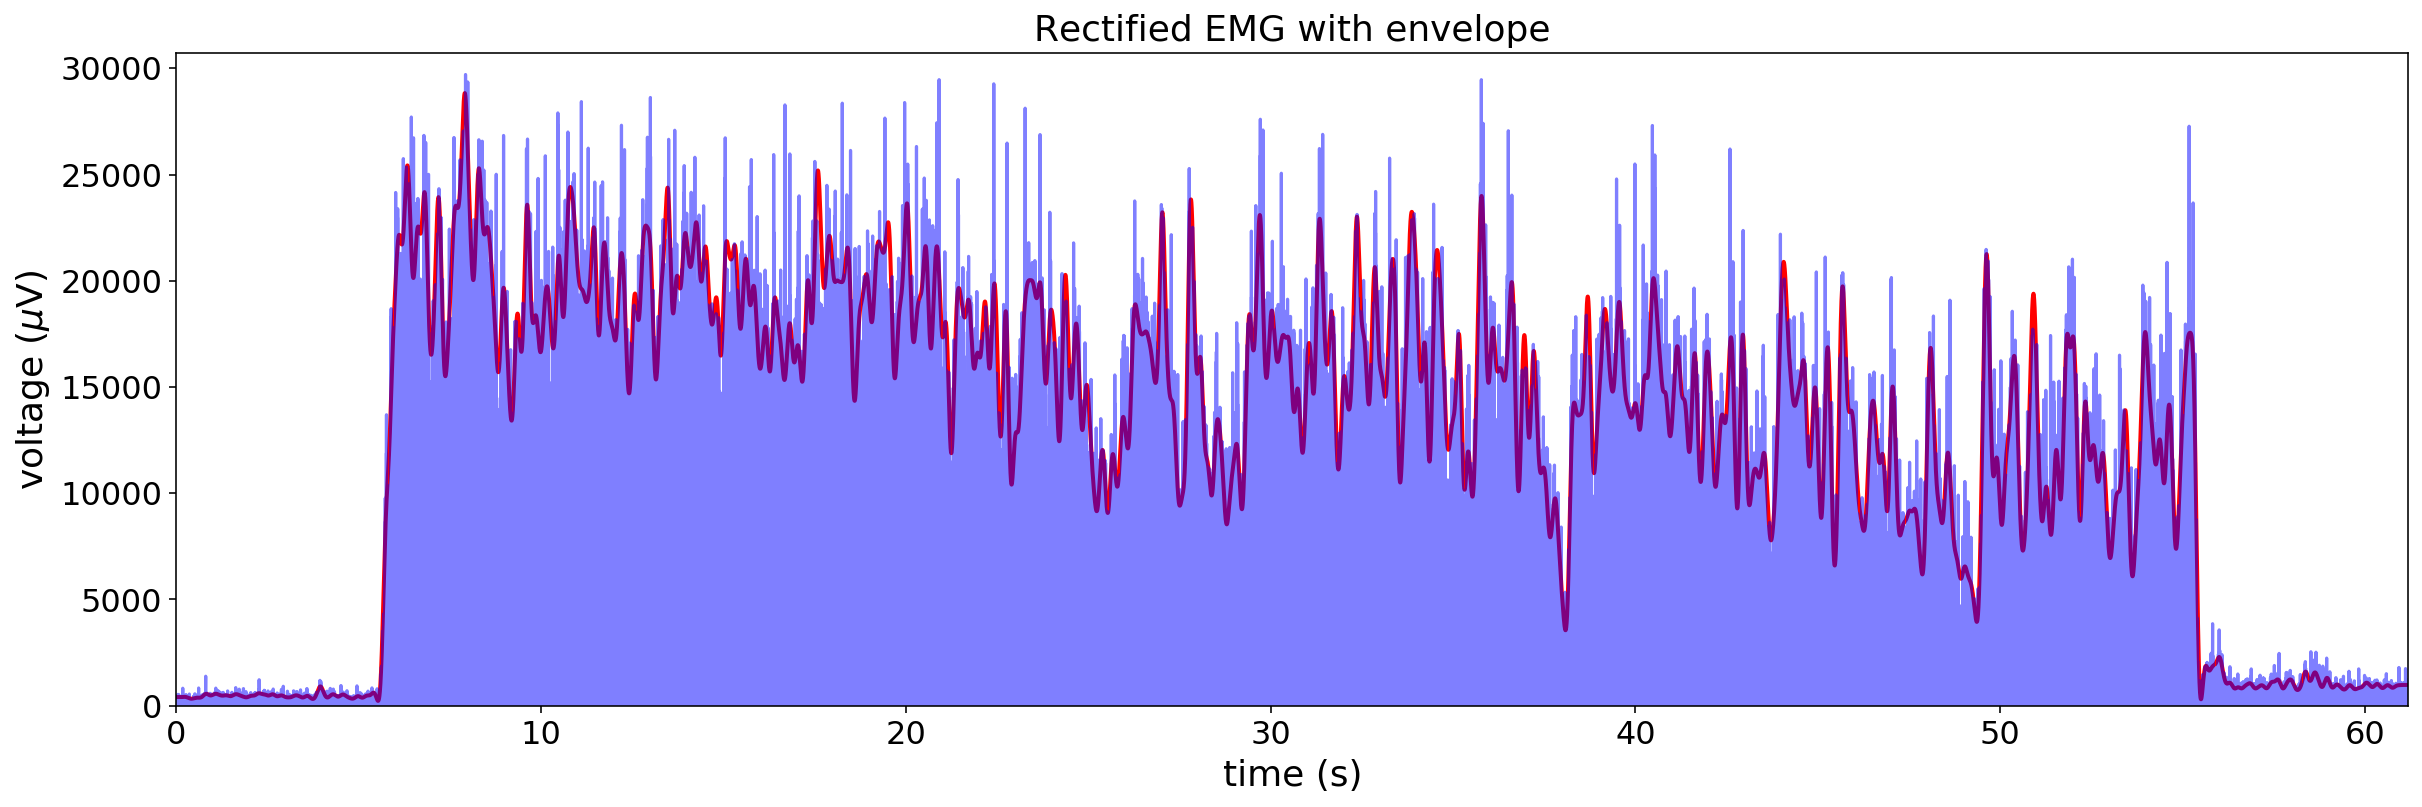

In [73]:
xx=analyzeEMG(file='/users/emckiernan/grants/PAPIME/mc0.wav',graph=1)

As we can see in the above recording, the amplitude of the signal decreases as the recording progresses and the muscle presumably fatigues. One way to quantify this is to bin the data and find the maximum amplitude of the signal within each bin. For ease, we divide the data into 1 second bins. 

In [74]:
# calculate the number of 1 second bins in the recording
# use 'floor' to ensure number is expressed as integer
nbins = math.floor(len(xx['waveData'])/sampleRate)
print('The recording has %d bins of 1 second duration.' % (nbins))

# define a function to create bins
# code adapted from https://www.python-course.eu/pandas_python_binning.php
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """   

    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

# run the above function to create bins
secBins = create_bins(0,sampleRate,nbins)

The recording has 61 bins of 1 second duration.


Next, we iterate over the bins, calculating the maximum amplitude for each bins to see how it changes over the course of the recording. 

In [75]:
x = secBins
y = xx['absSignal']
maxamps = []

for n in range(0,len(x)):
    maxAmp=y[min(x[n]):max(x[n])].max()
    maxamps.append(maxAmp)

Now we plot the results, with each point representing the maximum amplitude of the EMG signal within each bin.

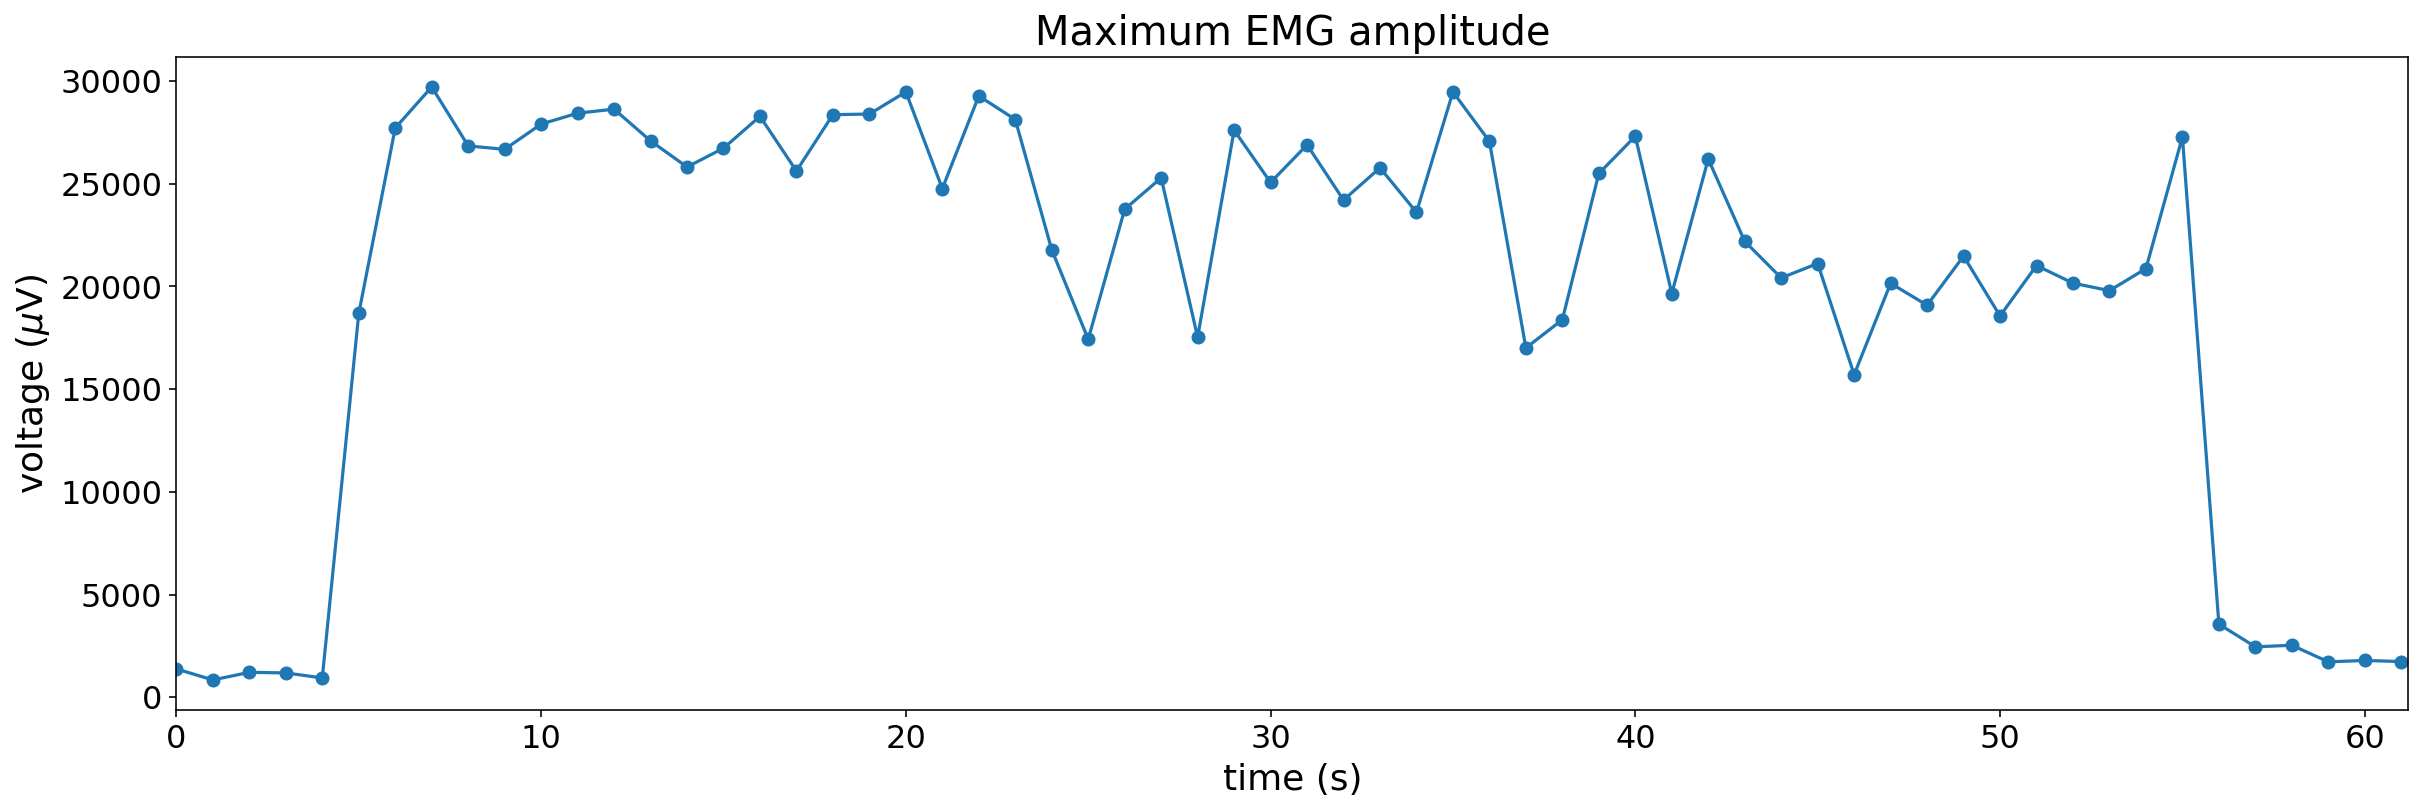

In [76]:
plt.figure(figsize=(20,6))
plt.plot(maxamps,'o-')
plt.title('Maximum EMG amplitude')
plt.xlabel('time (s)')
plt.xlim(0,max(xx['timeEMG']))
plt.ylabel(r'voltage ($\mu$V)');

The above graph shows that the maximum amplitude decreases slightly as the recording progresses. However, outliers make the trend a less clear than it might be. Instead, we can also iterate over the bins and calculate the mean amplitude to see if that gives us a clearer picture of the decrease due to fatigue.

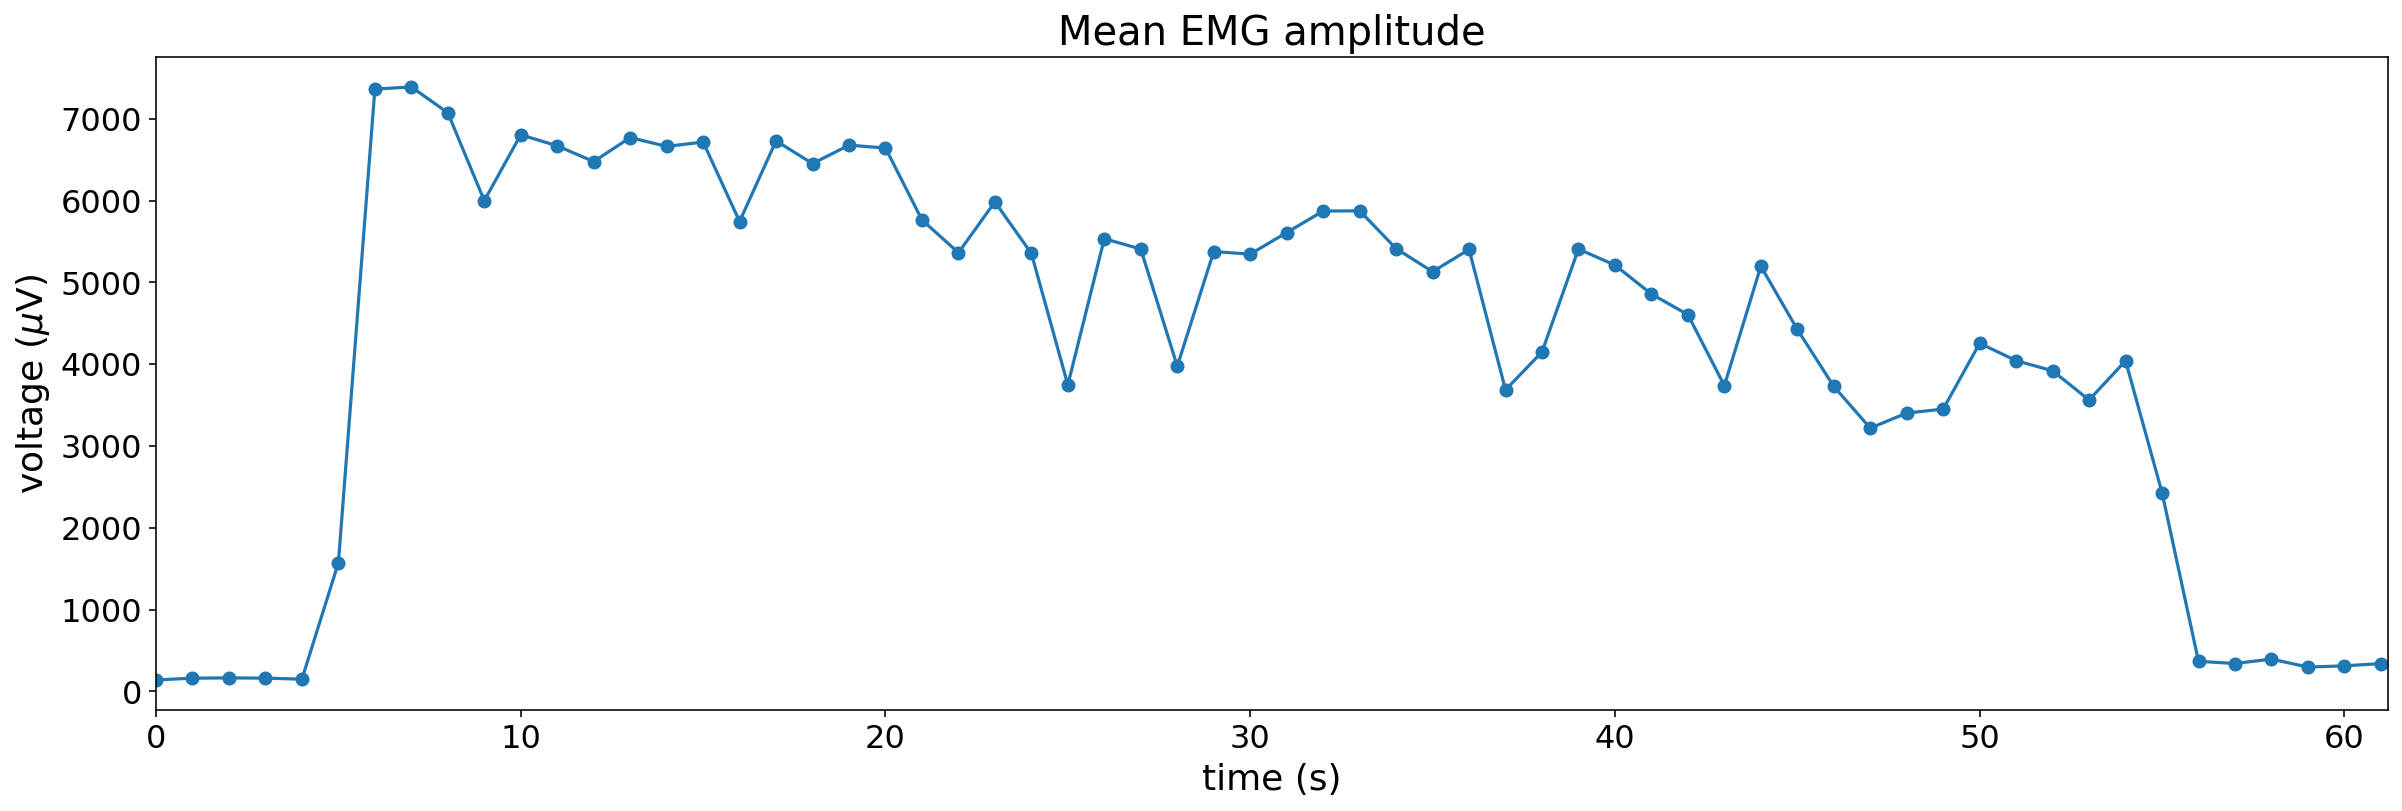

In [77]:
# calculate mean amplitude over bins
meanamps = []
for n in range(0,len(x)):
    meanAmp=y[min(x[n]):max(x[n])].mean()
    meanamps.append(meanAmp)

# plot results
plt.figure(figsize=(20,6))
plt.plot(meanamps,'o-')
plt.title('Mean EMG amplitude')
plt.xlabel('time (s)')
plt.xlim(0,max(xx['timeEMG']))
plt.ylabel(r'voltage ($\mu$V)');

In this case, the trend is much clearer and we can see how the mean amplitude decreases throughout the recording, indicating muscle fatigue. One crude but effective way to calculate the size of the decrease is by taking the difference between the peak mean amplitudes at the beginning (bin 6) and end (bin 54) of the recording.

In [78]:
ampChange = meanamps[6] - meanamps[54]
print(ampChange)

3321.231964621004


Muscle fatigue is also marked by a decrease in the frequency of the EMG signal, which can result from both a decrease in the firing rate of individual motor units and a decrease in the total number of active motor units. We can quantify this by iterating over the 1 second bins as before, but this time calculating the median power frequency as follows.

NEED MEAN/MEDIAN POWER FREQUENCY CALCULATION HERE

NOTE: NEXT PART IS ATTEMPT AT EVENT DETECTION WITH 'DEADSPACE/REFRACTORY PERIOD', BUT NOT WORKING WELL YET. NEED TO FIX.

In [79]:
# from https://mcspydatatools.readthedocs.io/en/latest/McsPy-Tutorial_DataAnalysis.html
def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return them as an array

    The signal transitions from a sample above the threshold to a sample below the threshold 
    for a detection and the last detection has to be more than dead_time apart from the 
    current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff((signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    return threshold_crossings

def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

def align_to_minimum(signal, fs, threshold_crossings, search_range):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)

In [80]:
xx=analyzeEMG(file='/users/emckiernan/grants/PAPIME/mc0.wav',graph=0)
fs = sampleRate
crossings = detect_threshold_crossings(xx['absSignal'], fs, 2000, 0.002) # dead time of 2 ms
spks = align_to_minimum(xx['absSignal'], fs, crossings, 0.001) # search range 1 ms

In [81]:
spikes=[]
for n in range(0, len(spks)):
    stime = spks[n]/sampleRate
    spikes.append(stime)
    
crosses=[]
for n in range(0, len(crossings)):
    ctime = crossings[n]/sampleRate
    crosses.append(ctime)

NOTE: FOLLOWING TAKES TIME! WAY TO OPTIMIZE?

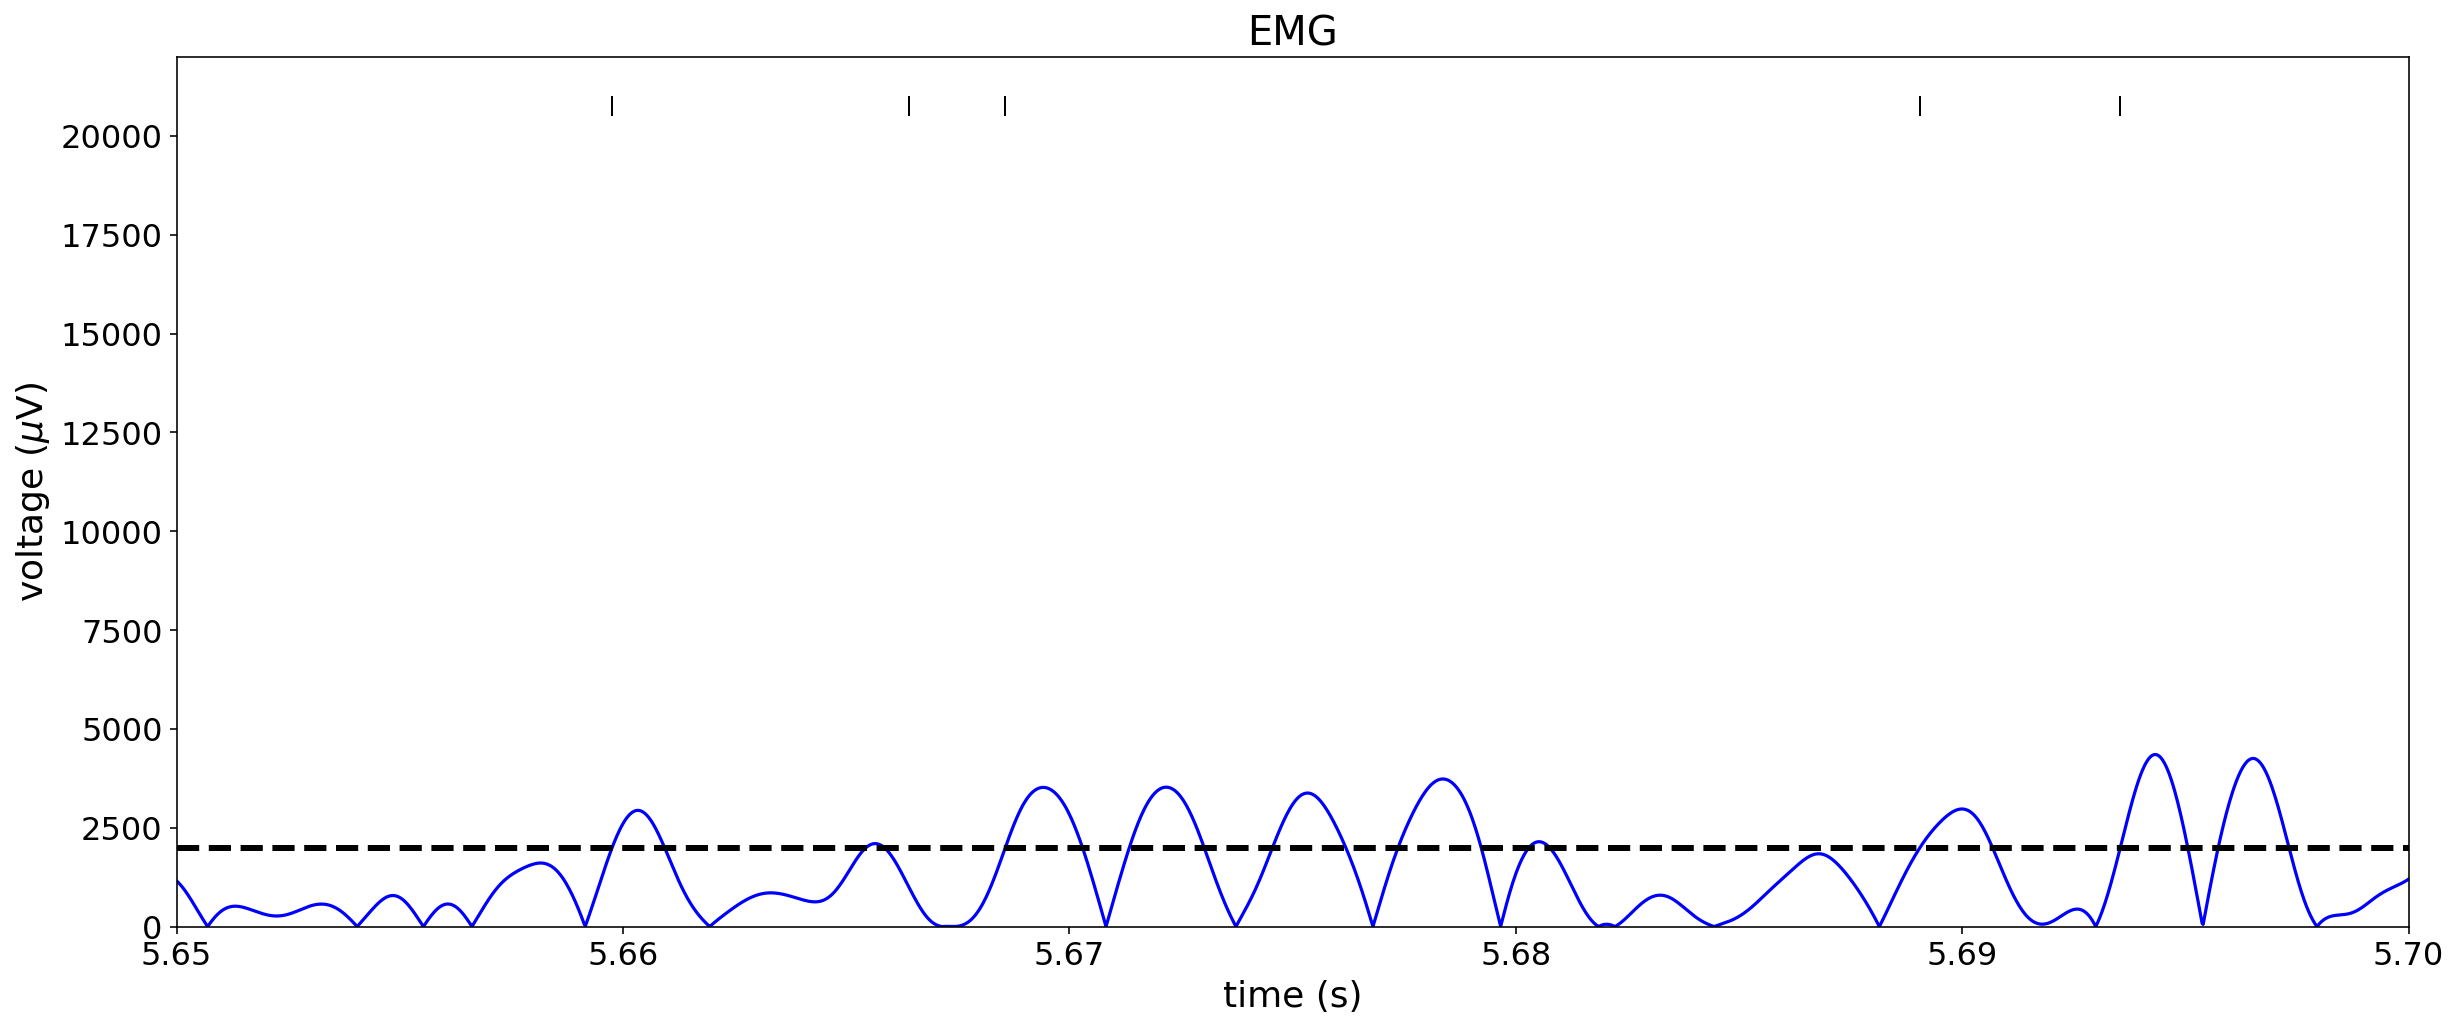

In [82]:
plt.figure(figsize=(20,8))
plt.title('EMG')
plt.xlabel('time (s)')
plt.ylabel('voltage ($\mu$V)')
plt.plot(xx['timeAbs'],xx['absSignal'], 'b')
plt.xlim(0,max(xx['timeEMG']))
plt.axhline(y=2000, color='k',linewidth=3.0, linestyle='--') 
for n in range(0, len(spikes)):
    plt.vlines(x=spikes[n], ymin=20500, ymax=21000, color='k',linewidth=1.0, linestyle='-')
plt.xlim(5.65,5.7)
plt.ylim(0,22000)
plt.show()

#### Muscle fatigue across trials

Muscles also fatigue with repeated contractions. We asked subjects to repeat the above exercise (holding a weight with the arm bent at 90 degrees for 50 seconds) for 10 trials with 60 seconds rest between each trial. Trial 0, analyzed above, is the first trial (i.e. before fatigue through repetition) and trial 9 is the last repetition, i.e. after fatigue.

There are several measures we could use to quantify fatigue. One is the **maximum amplitude** of the EMG signal. If repeated trials fatigue the muscle, then the maximum contraction subjects generate during trial 9 should be less than that generated during trial 0, and we will see a decrease in the maximum amplitude. Second, we can calculate the **root mean square (RMS)** of the signal, which should also decrease with fatigue. Finally, we calculate the **total area** of the envelope signal, i.e. the maximum of the cumulative sum, which should decrease as well. 

First, we run our analysis function on trials 0 and 9 for a given subject (MC) and graph the two recordings.

In [83]:
# specify files to be analyzed
EMGfiles = ['/users/emckiernan/grants/PAPIME/mc0.wav',\
            '/users/emckiernan/grants/PAPIME/mc9.wav']

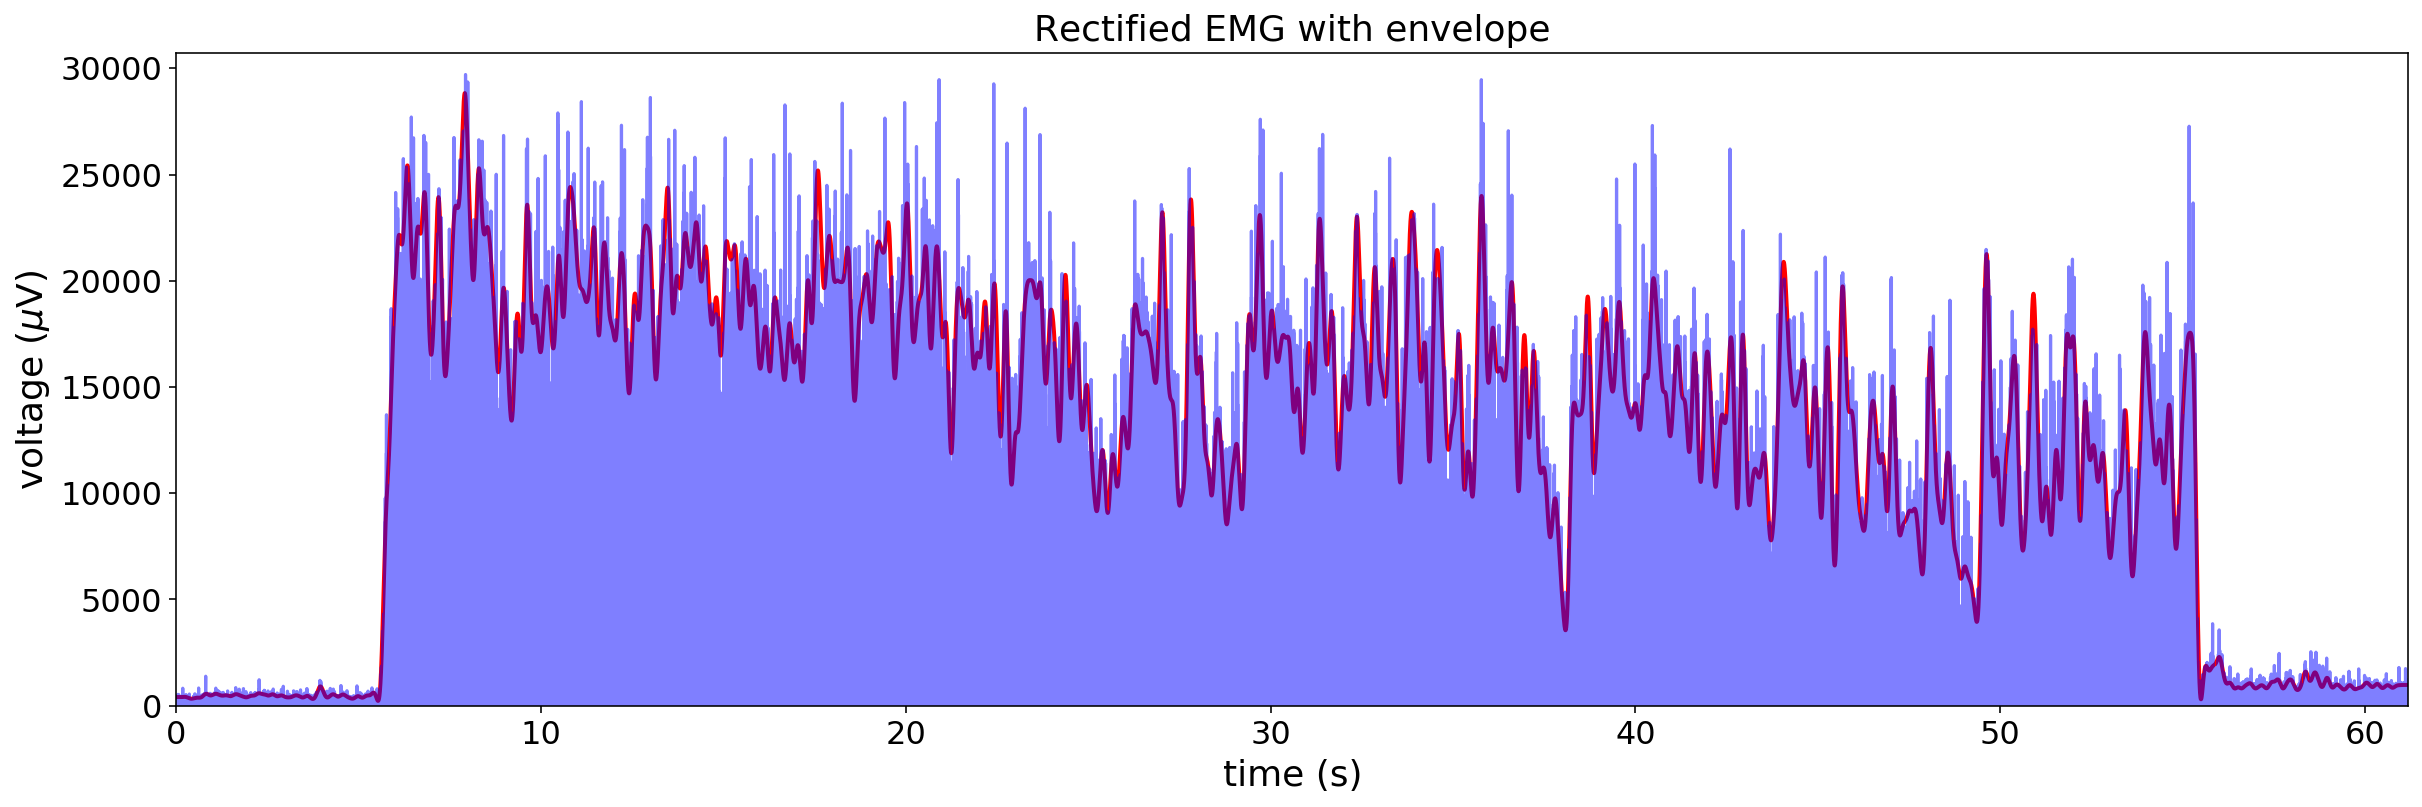

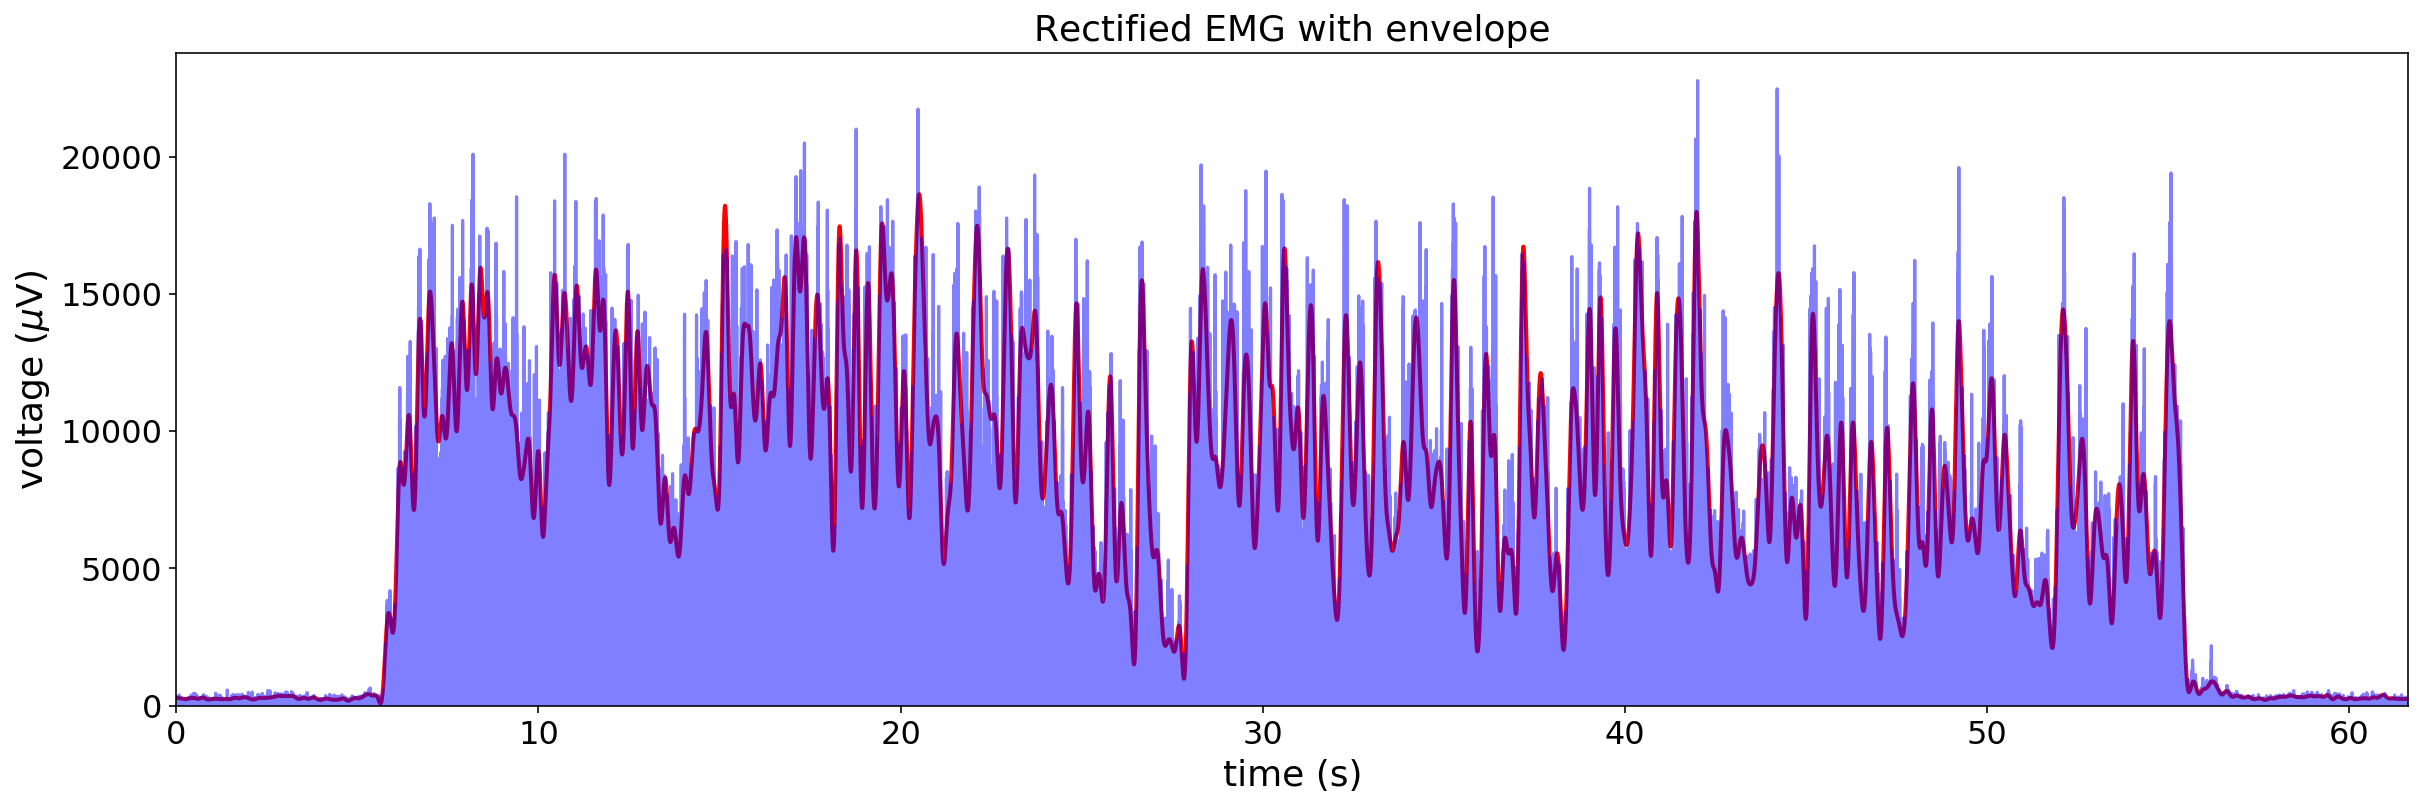

In [84]:
# create an empty array to store data
data = []
# iterate over each recording to analyze and graph
for record in EMGfiles:
    xx= analyzeEMG(record,graph=1)
    data.append(xx)

Now, we calculate the maximum amplitude (maxamps), the maximum cumulative sum (maxsums), and RMS (rmss) for trials 0 and 9, and then generate bar graphs to compare each measure before and after fatigue.

In [85]:
# create empty arrays to hold measures
maxsums = []
maxamps = []
rmss = []

# for loop to iterate over recordings
for n in range(len(data)):
    # calculate the maximum amplitude 
    maxamp=max(data[n]['absSignal'])
    maxamps.append(maxamp)
    # calculate the cumulative sum 
    sumSignal = np.cumsum(data[n]['absSignal'])
    # calculate the max of the cumulative sum, i.e. the total area
    maxsum = max(sumSignal)
    maxsums.append(maxsum)
    # calculate RMS
    rms=np.sqrt(np.mean(data[n]['absSignal']**2))
    rmss.append(rms)

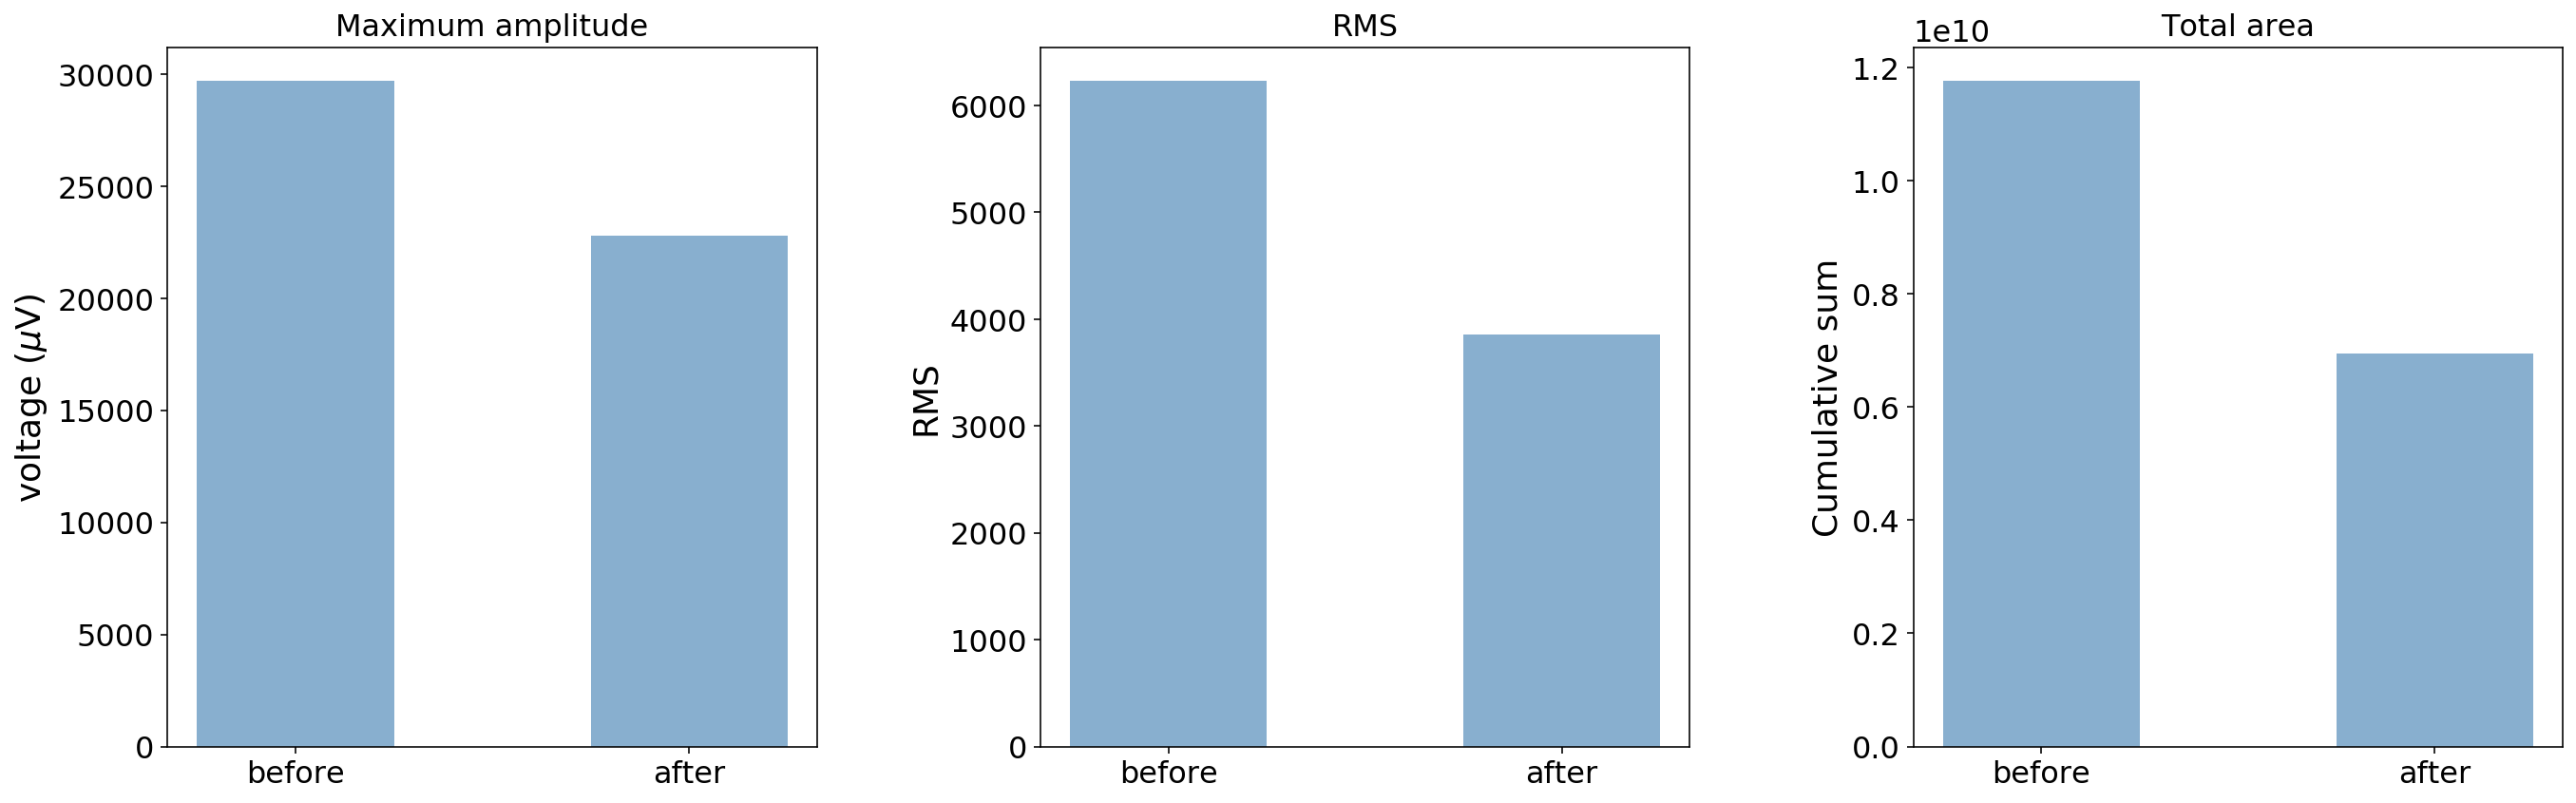

In [86]:
# set labels for each bar graph
labels = ('before','after')
y_pos = [0,1]

plt.figure(figsize=(20,7)) 

# plot and compare maximum amplitudes
plt.subplot(1, 3, 1)
for n in range(len(maxamps)):
    plt.bar(y_pos,maxamps,width=0.5,align='center',color='steelblue',alpha=0.4)
    plt.xticks(y_pos, labels)
    plt.title('Maximum amplitude',fontsize=16)
    plt.ylabel('voltage ($\mu$V)')
    #plt.ylim(0,max(measure1)+1000)

# plot and compare RMS
plt.subplot(1, 3, 2)
for n in range(len(rmss)):
    plt.bar(y_pos,rmss,width=0.5,align='center',color='steelblue',alpha=0.4)
    plt.xticks(y_pos, labels)
    plt.title('RMS',fontsize=16)
    plt.ylabel('RMS')

# plot and compare total area
plt.subplot(1, 3, 3)
for n in range(len(maxsums)):
    plt.bar(y_pos,maxsums,width=0.5,align='center',color='steelblue',alpha=0.4)
    plt.xticks(y_pos, labels)
    plt.title('Total area',fontsize=16)
    plt.ylabel('Cumulative sum')
    #plt.ylim(0,max(measure3)+1e8)


plt.tight_layout(pad=3.0)

We can see that for all three measures, there is a noticeable decrease when we compare the first to the last trial, indicating that the protocol of repeated contractions induced fatigue in the bicep muscle.

If we want to see how each measure changed over the entire protocol, we can run the analysis on all trials and plot the measures as functions of trial number.

In [87]:
# specify the complete set of files to be analyzed
EMGfiles = ['/users/emckiernan/grants/PAPIME/mc0.wav',\
            '/users/emckiernan/grants/PAPIME/mc1.wav',\
            '/users/emckiernan/grants/PAPIME/mc2.wav',\
            '/users/emckiernan/grants/PAPIME/mc3.wav',\
            '/users/emckiernan/grants/PAPIME/mc4.wav',\
            '/users/emckiernan/grants/PAPIME/mc5.wav',\
            '/users/emckiernan/grants/PAPIME/mc6.wav',\
            '/users/emckiernan/grants/PAPIME/mc7.wav',\
            '/users/emckiernan/grants/PAPIME/mc8.wav',\
            '/users/emckiernan/grants/PAPIME/mc9.wav']

In [88]:
# create an empty array to store data
data = []
# iterate over each recording to analyze and graph
for record in EMGfiles:
    xx= analyzeEMG(record,graph=0)
    data.append(xx)

In [89]:
# create empty arrays to hold measures
maxsums = []
maxamps = []
rmss = []

# for loop to iterate over recordings
for n in range(len(data)):
    # calculate the maximum amplitude 
    maxamp=max(data[n]['absSignal'])
    maxamps.append(maxamp)
    # calculate the cumulative sum 
    sumSignal = np.cumsum(data[n]['absSignal'])
    # calculate the max of the cumulative sum, i.e. the total area
    maxsum = max(sumSignal)
    maxsums.append(maxsum)
    # calculate RMS
    rms=np.sqrt(np.mean(data[n]['absSignal']**2))
    rmss.append(rms)

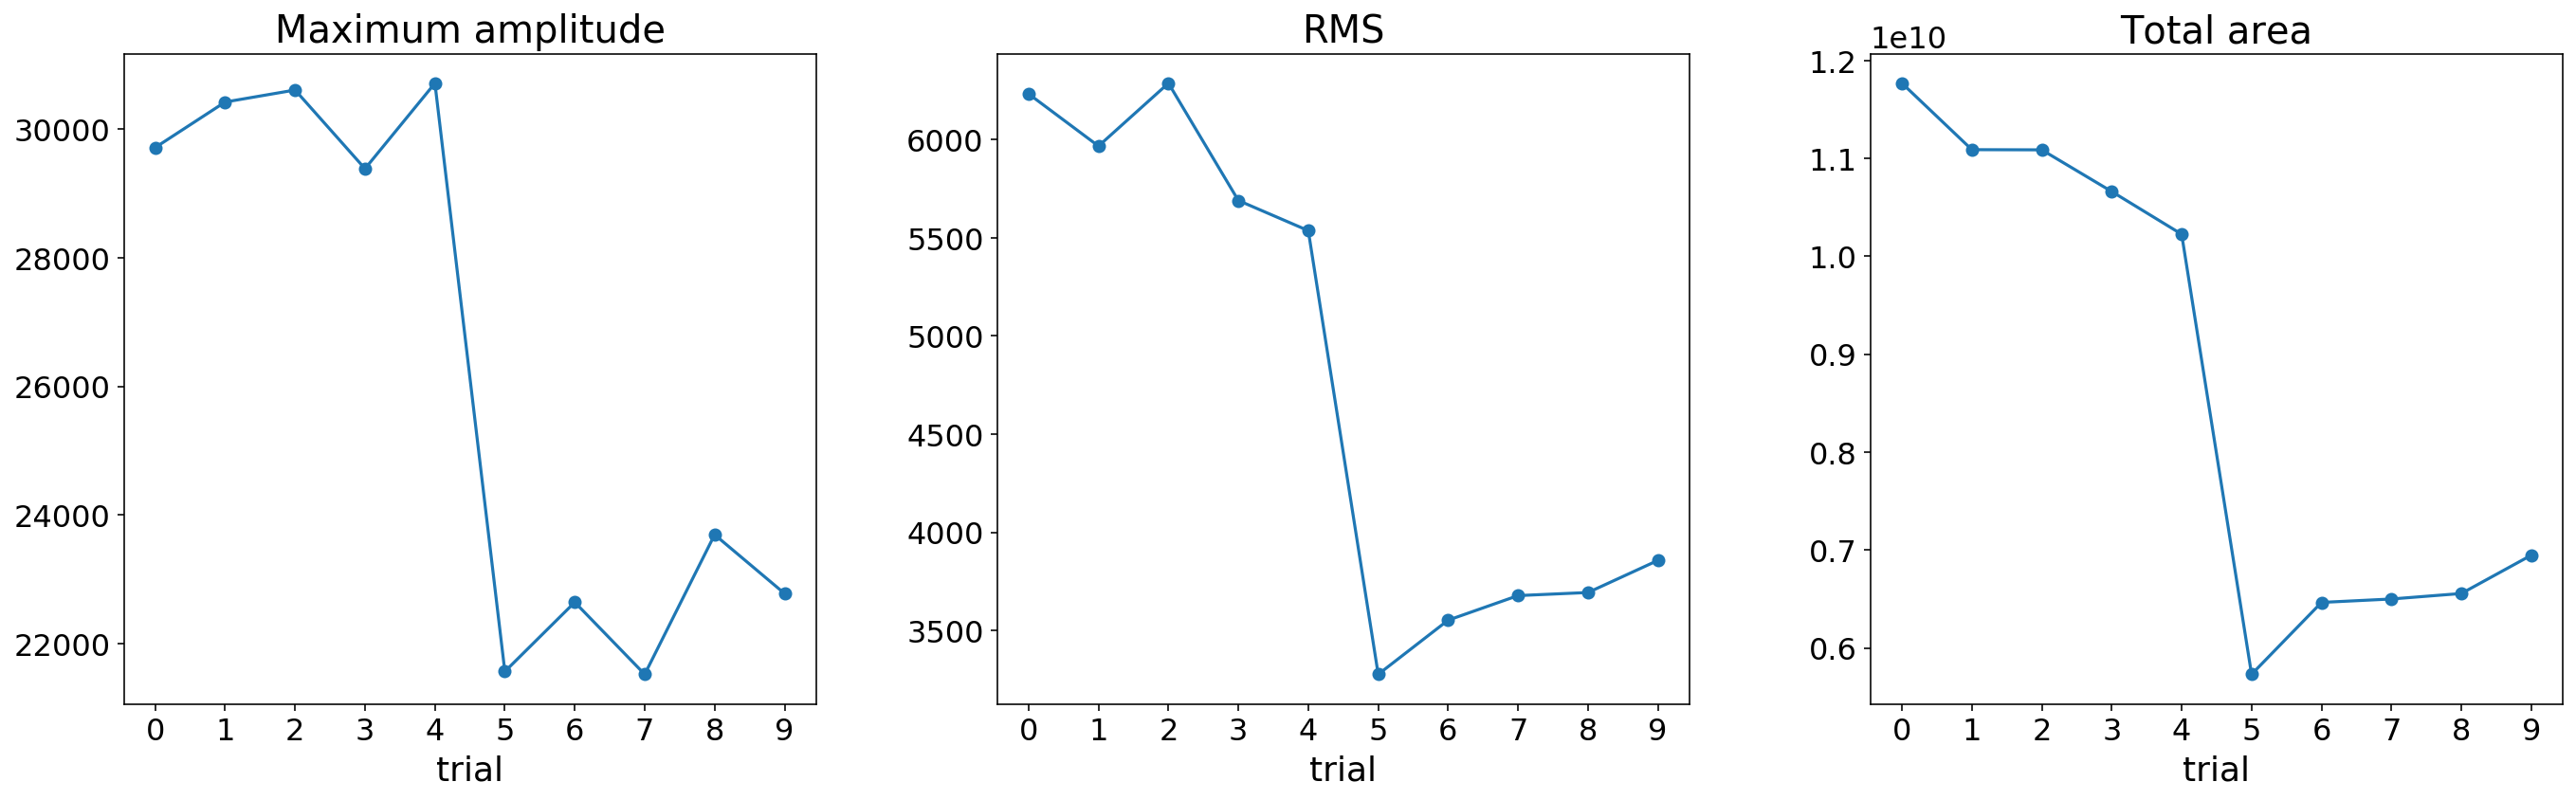

In [90]:
# plot and compare measures over all trials
plt.figure(figsize=(20,7)) 

# plot maximum amplitudes 
plt.subplot(1, 3, 1)
plt.plot(maxamps,'o-')
plt.xticks(np.arange(0, 10, step=1))
plt.xlabel('trial')
plt.title('Maximum amplitude')

# plot RMS
plt.subplot(1, 3, 2)
plt.plot(rmss,'o-');
plt.xticks(np.arange(0, 10, step=1))
plt.xlabel('trial')
plt.title('RMS')

# plot total area
plt.subplot(1, 3, 3)
plt.plot(maxsums,'o-')
plt.xticks(np.arange(0, 10, step=1))
plt.xlabel('trial')
plt.title('Total area')

plt.tight_layout(pad=3.0)

For this subject, we can see there is a marked decrease in all measures at trial 5, indicating fatigue. The exact nature of the decrease and the trial number when fatigue sets in will likely vary by subject, but we expect the general trend to be the same. 

In [91]:
# specify the files to be analyzed
EMGfiles = ['/users/emckiernan/grants/PAPIME/mc0.wav',\
            '/users/emckiernan/grants/PAPIME/mc9.wav']

# create an empty array to store data
data = []
# iterate over each recording to analyze and graph
for record in EMGfiles:
    xx= analyzeEMG(record,graph=0)
    data.append(xx)

# get the number of bins for each recording
nbins = []
for n in range(len(data)):
    numbins = math.floor(len(data[n]['waveData'])/sampleRate)
    nbins.append(numbins)       

# create the 1 second bins for each recording
binRecs = []
for n in range(len(nbins)):
    secBins = create_bins(0,sampleRate,nbins[n])
    binRecs.append(secBins)   

In [92]:
# calculate maximum amplitudes over bins for each recording
maxamps = [[],[]]
for n in range(0,len(binRecs)):
    for i in range(0,len(binRecs[n])):
        maxAmp=data[n]['absSignal'][min(binRecs[n][i]):max(binRecs[n][i])].max()
        maxamps[n].append(maxAmp)

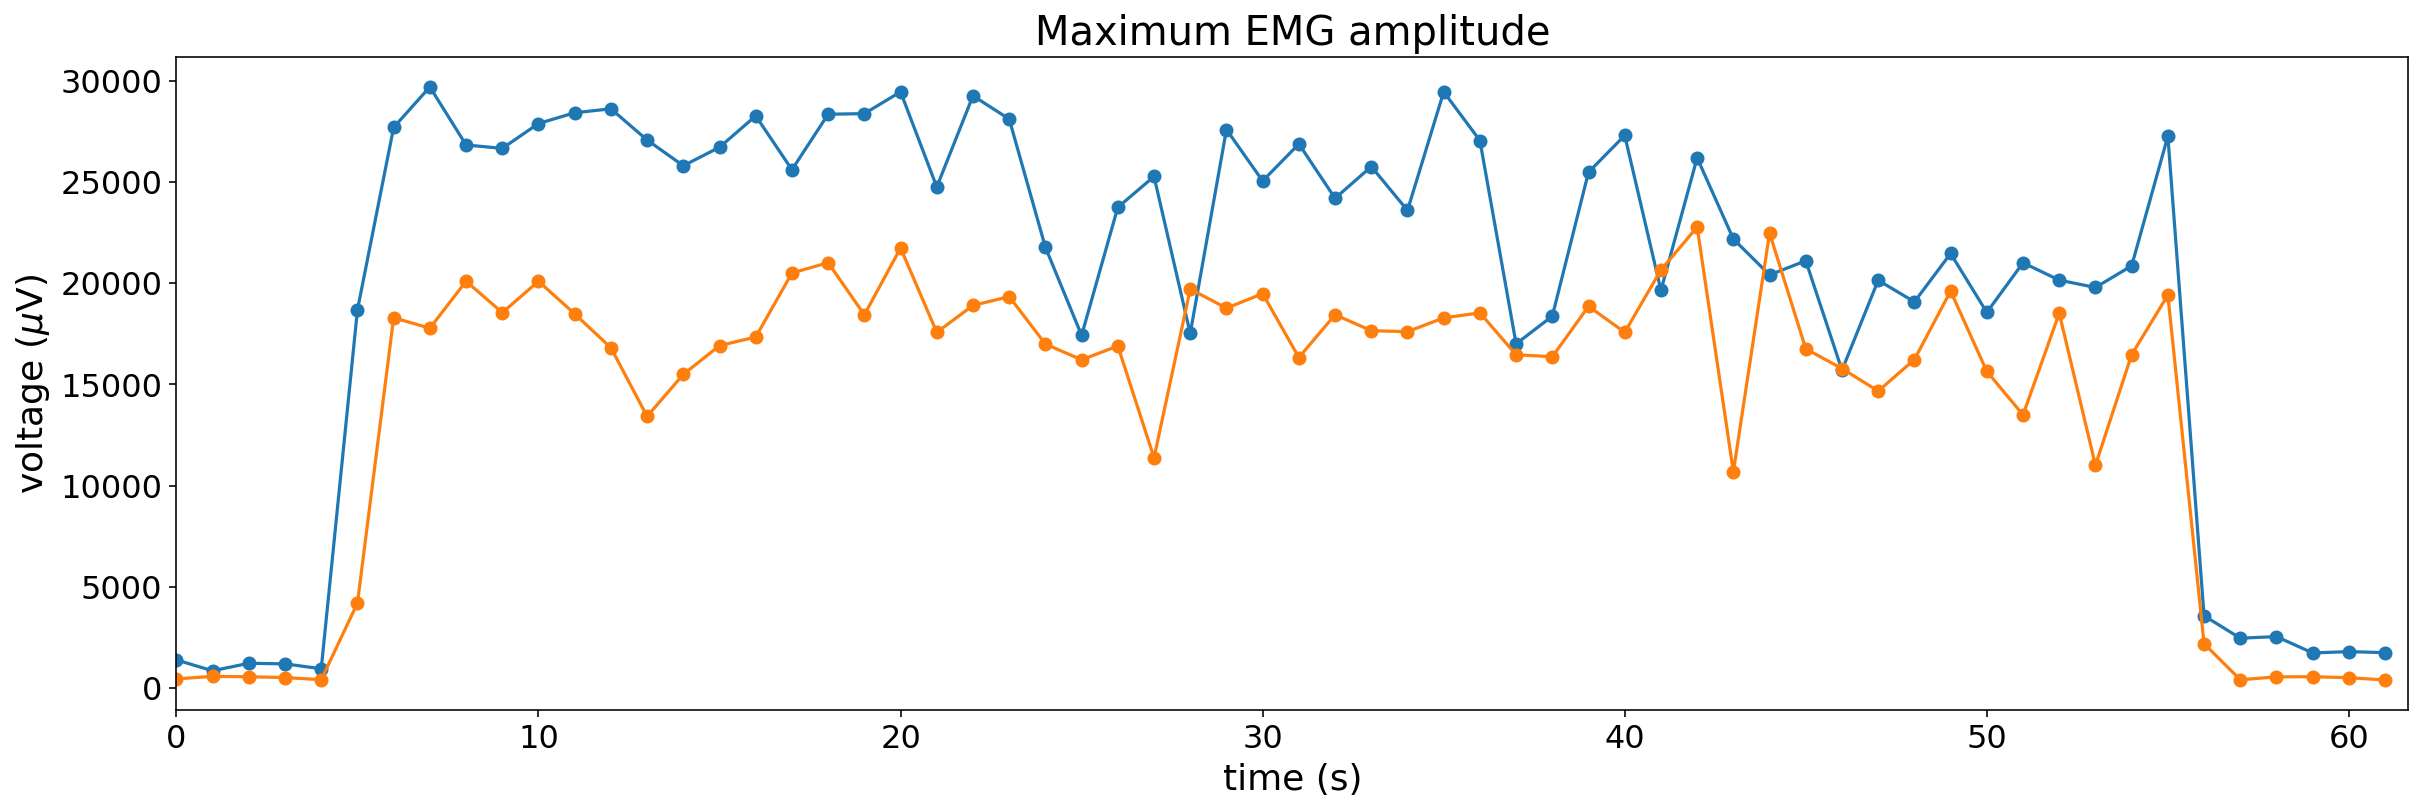

In [93]:
# plot results from the above calculations; trial 0 in blue, trial 9 in orange
plt.figure(figsize=(20,6))
for n in range(0,len(maxamps)):
    plt.plot(maxamps[n],'o-')
    plt.title('Maximum EMG amplitude')
    plt.xlabel('time (s)')
    plt.xlim(0,max(xx['timeEMG']))
    plt.ylabel(r'voltage ($\mu$V)')

In [94]:
# calculate mean amplitudes over bins for each recording
meanamps = [[],[]]
for n in range(0,len(binRecs)):
    for i in range(0,len(binRecs[n])):
        meanAmp=data[n]['absSignal'][min(binRecs[n][i]):max(binRecs[n][i])].mean()
        meanamps[n].append(meanAmp)

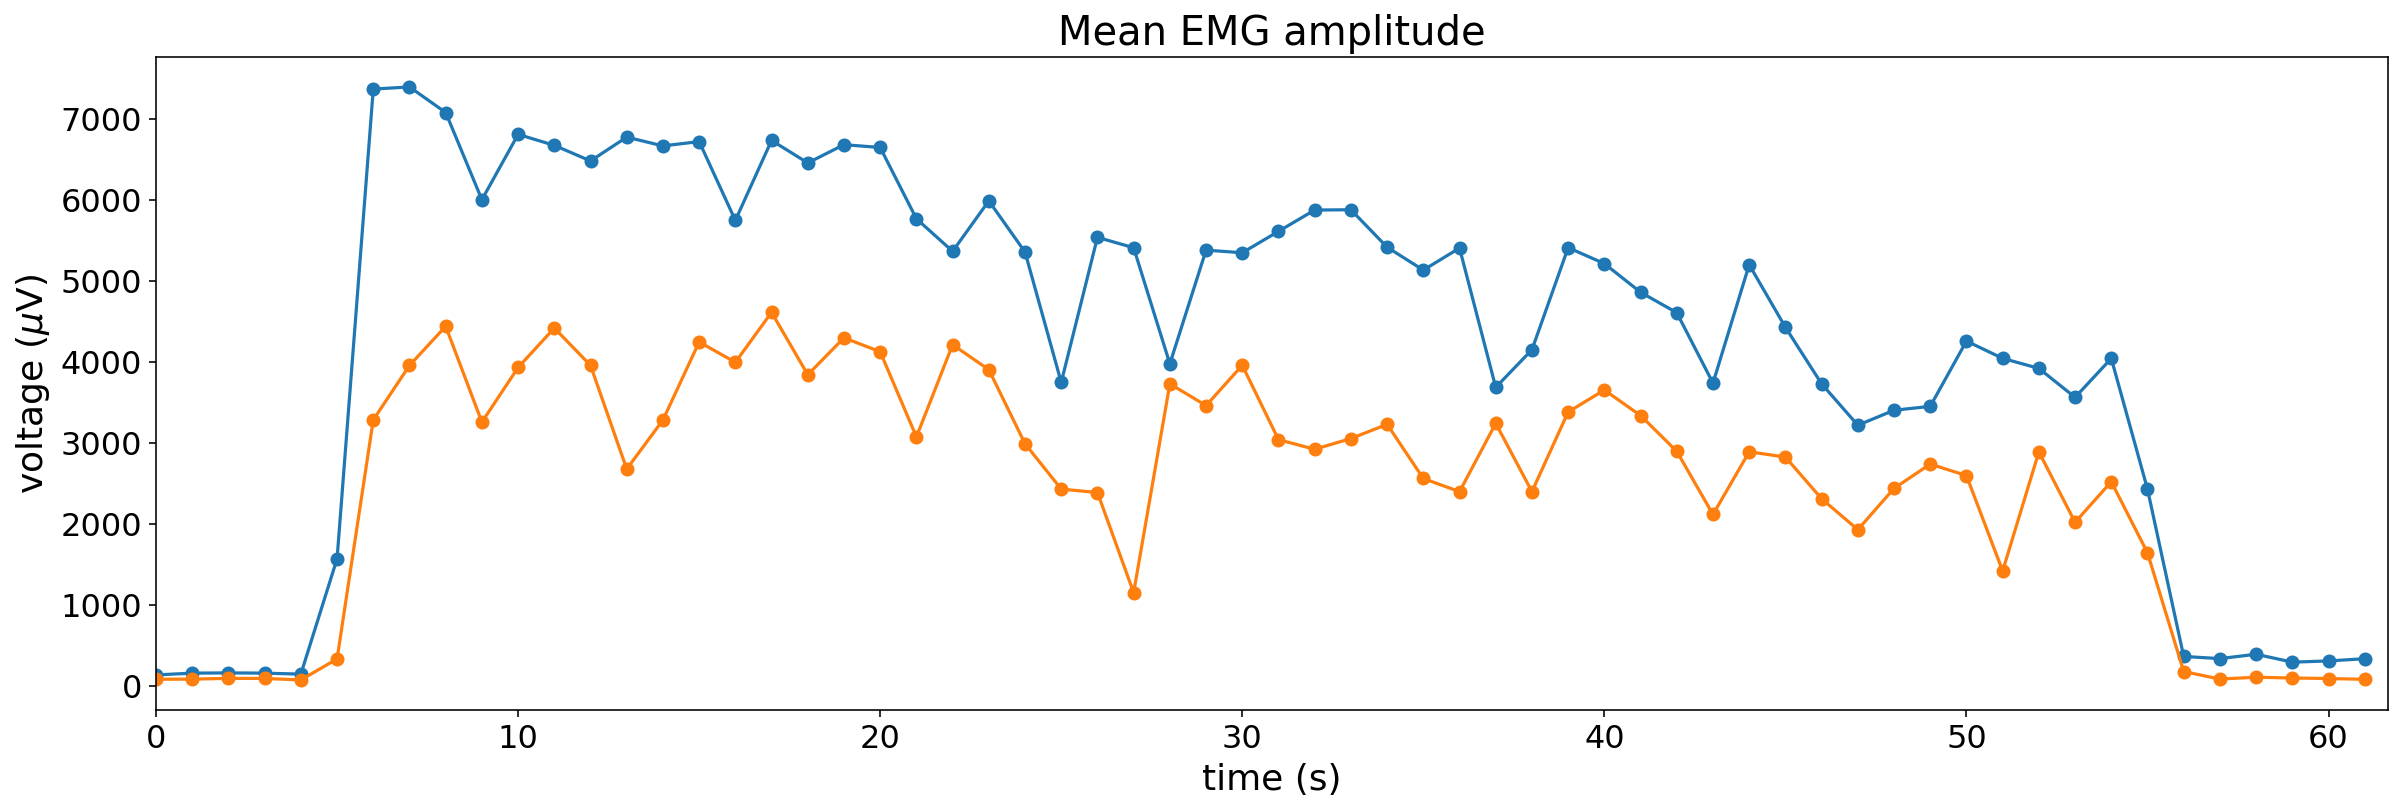

In [97]:
# plot results from the above calculation; trial 0 in blue, trial 9 in orange
plt.figure(figsize=(20,6))
for n in range(0,len(meanamps)):
    plt.plot(meanamps[n],'o-')
    plt.title('Mean EMG amplitude')
    plt.xlabel('time (s)')
    plt.xlim(0,max(xx['timeEMG']))
    plt.ylabel(r'voltage ($\mu$V)');

FOLLOWING ARE DIFFERENT WAYS OF DOING SPECTRAL ANALYSIS, NOT SURE WHICH IS BEST. NEED TO UNDERSTAND/WORK MORE ON THIS.

In [98]:
# adapted from https://kevinsprojects.wordpress.com/2014/12/13/short-time-fourier-transform-using-python-and-numpy/
# data = a numpy array containing the signal to be processed
# fs = a scalar which is the sampling frequency of the data

data = xx['absSignal']
fs = sampleRate
fft_size = 500
overlap_fac = 0.5
hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
pad_end_size = fft_size  # the last segment can overlap the end of the data array by no more than one window size
total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
t_max = len(data) / np.float32(fs)
 
window = np.hanning(fft_size)  # our half cosine window
inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size
 
proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result
 
for i in range(total_segments):                      # for each segment
    current_hop = hop_size * i                        # figure out the current segment offset
    segment = proc[current_hop:current_hop+fft_size]  # get the current segment
    windowed = segment * window                       # multiply by the half cosine function
    padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
    spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
    autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
    result[i, :] = autopower[:fft_size]               # append to the results array
 
result = 20*np.log10(result)          # scale to db
result = np.clip(result, -40, 200)    # clip values
result1=np.transpose(result)

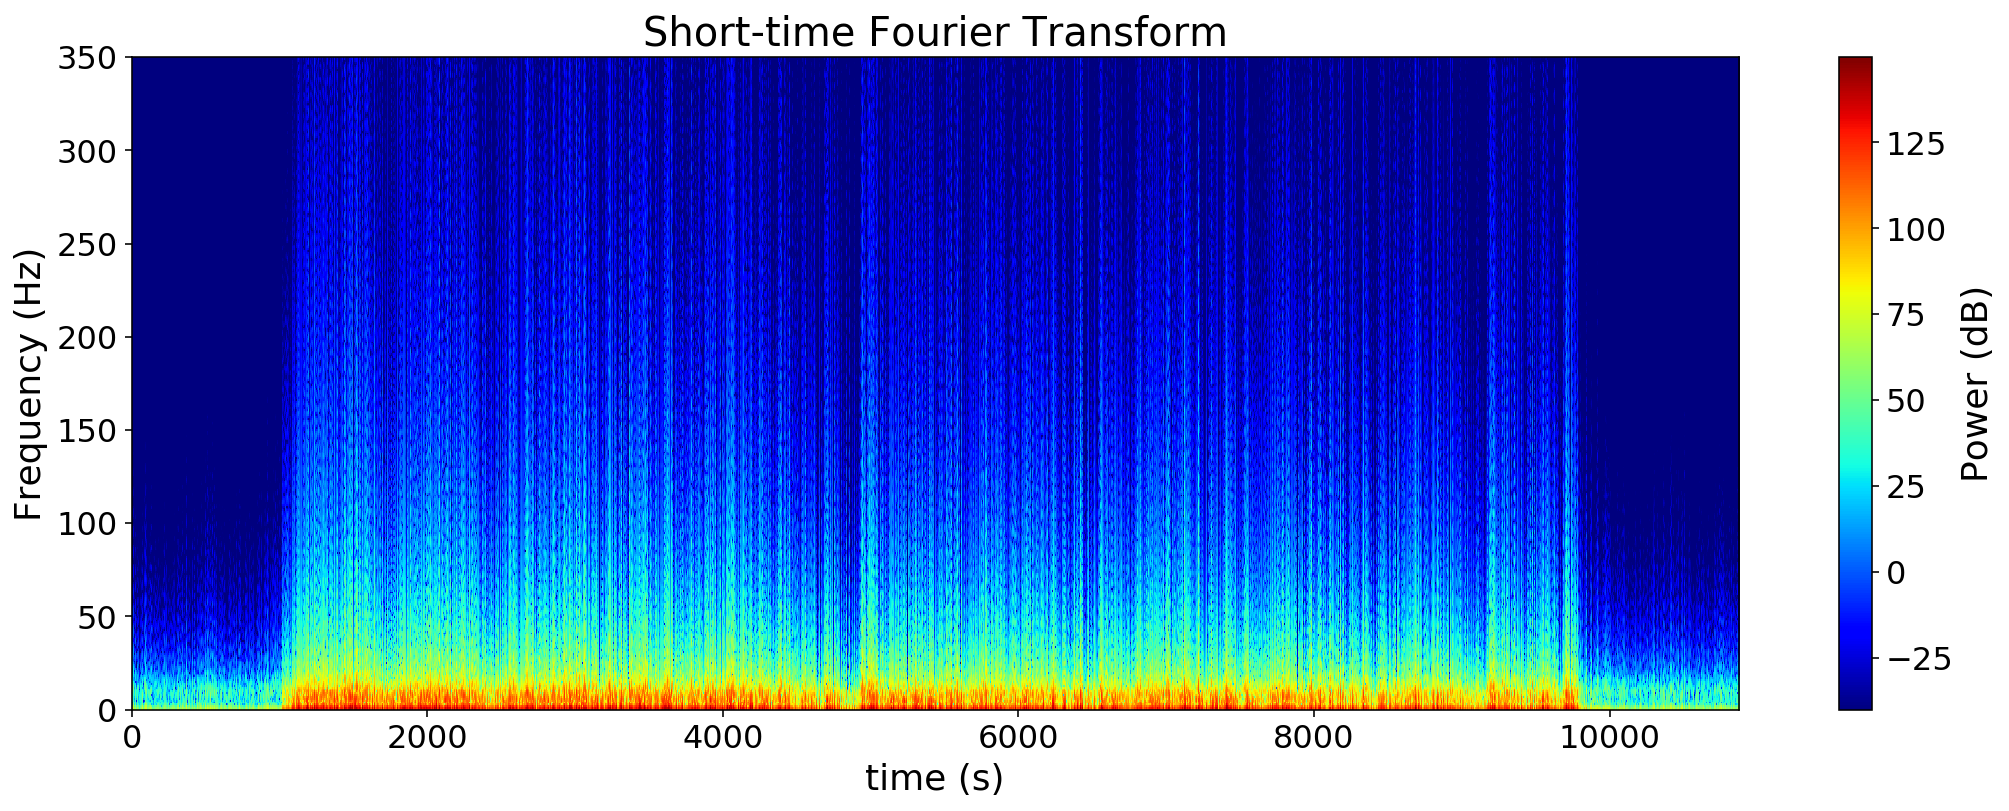

In [100]:
plt.figure(figsize=(18,6))
plt.title('Short-time Fourier Transform')
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.imshow(result1, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.colorbar(label='Power (dB)')
plt.ylim(0,350);

The following is done using built-in scipy function 'spectrogram'. Note that powers and x-axis scale are different, even though it is the same recording. Note also the values on y-axis.

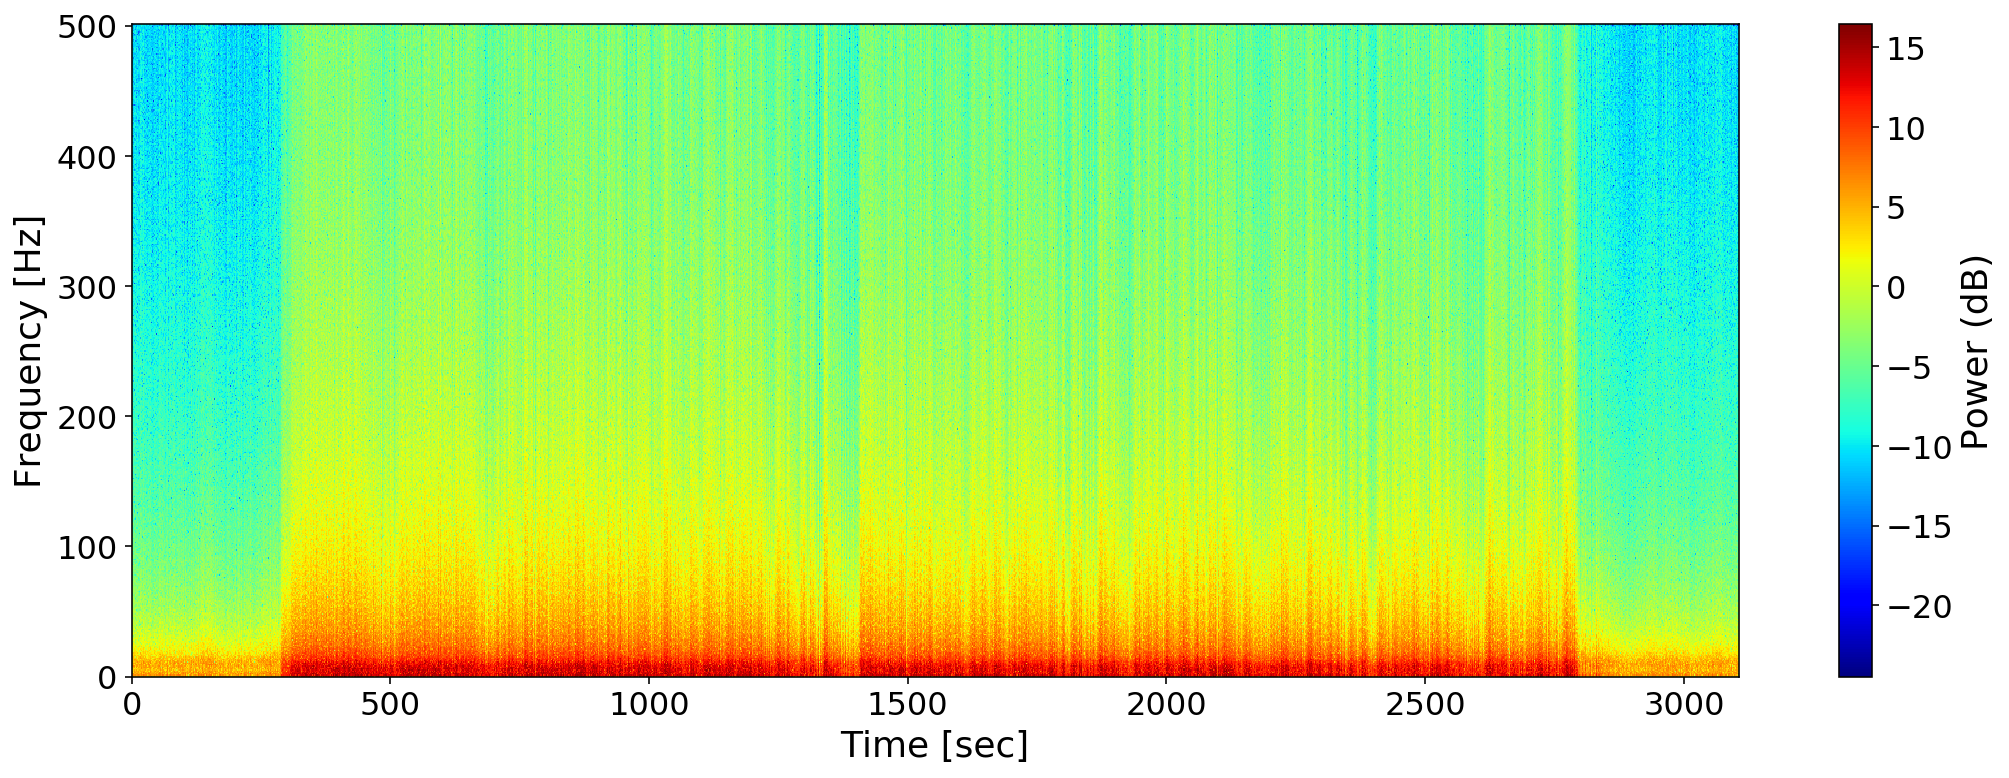

In [101]:
f, t, sxx = sc.signal.spectrogram(xx['absSignal'],sampleRate,nperseg=1000,scaling='spectrum')
plt.figure(figsize=(18,6))
plt.pcolormesh(np.log(sxx),cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power (dB)');

The following is done with built-in matplotlib 'specgram' function. In this case, max y-axis value is the Nyquist frequency (half the sampling rate). Note, change in x-axis (this is the correct time in seconds).

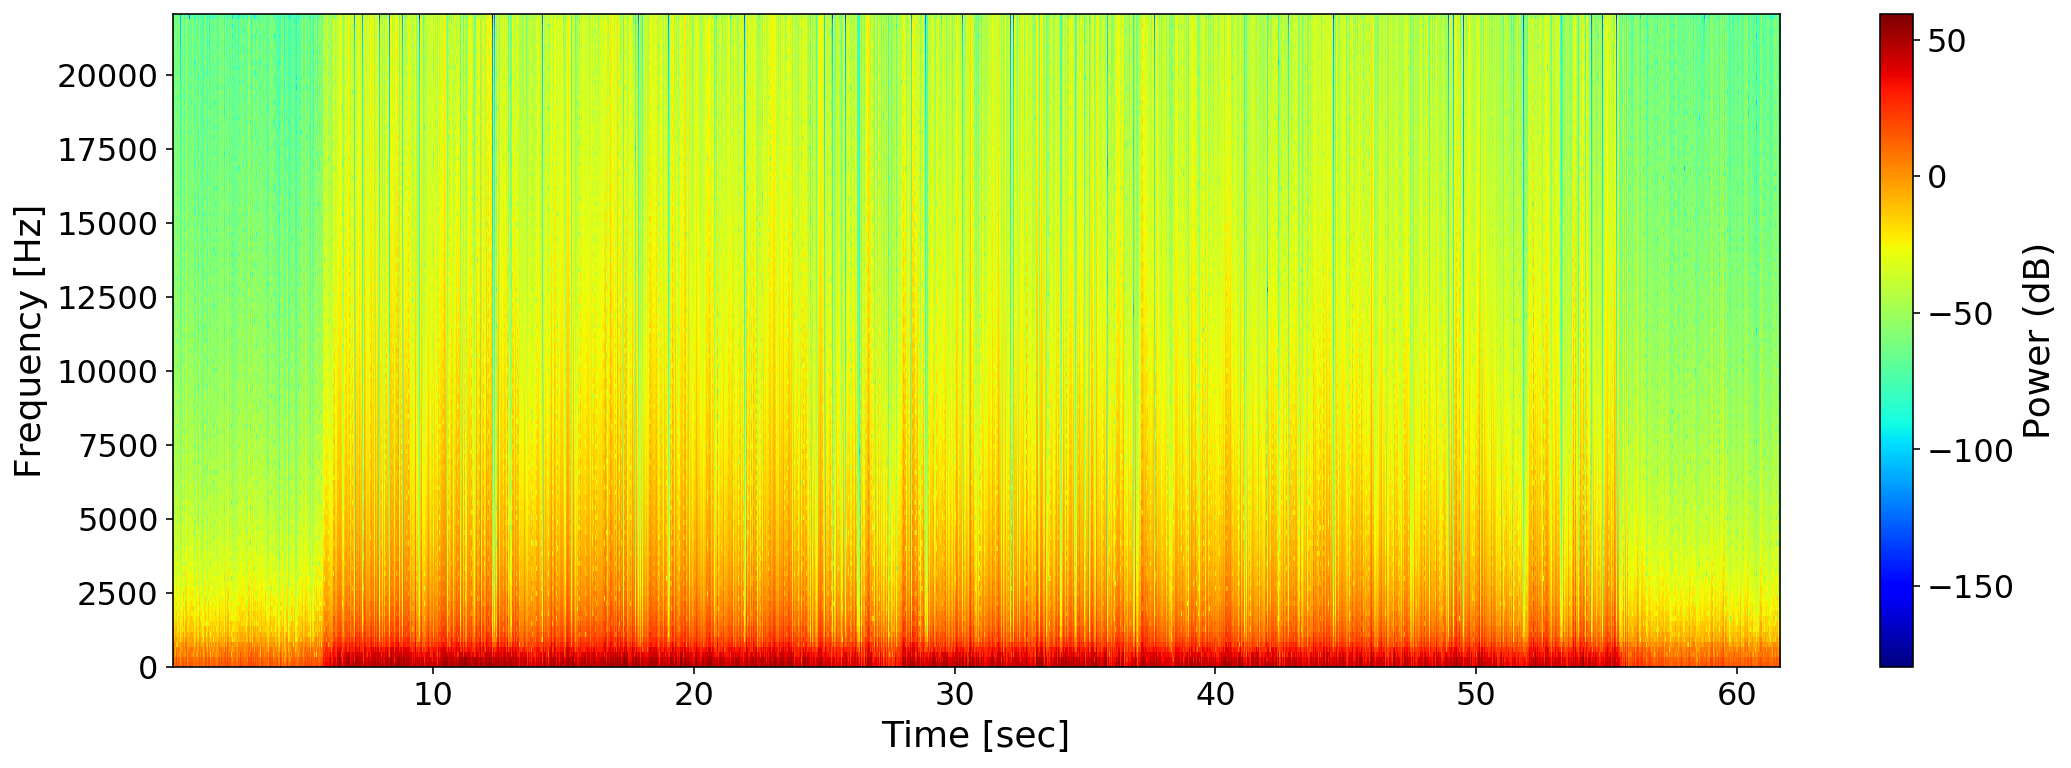

In [102]:
plt.figure(figsize=(18,6))
plt.specgram(xx['absSignal'],Fs=sampleRate,cmap='jet',scale_by_freq=None,mode='psd')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power (dB)');

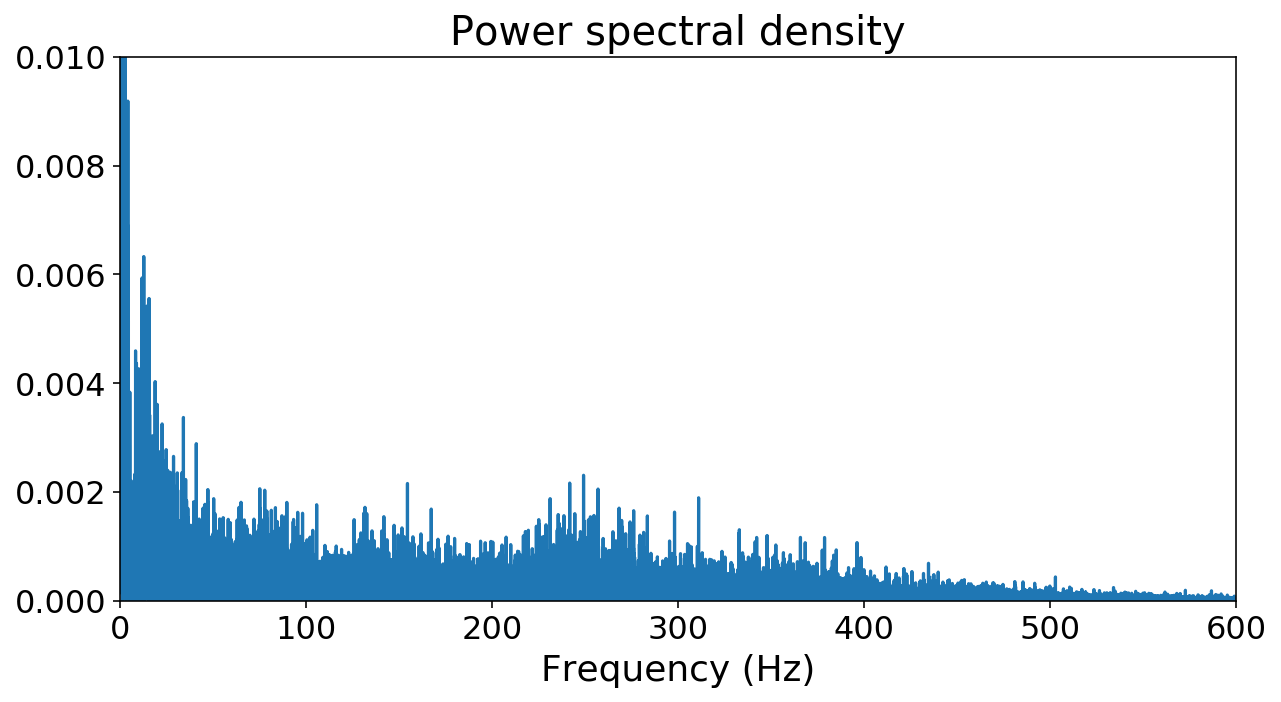

In [103]:
# power spectral density
def PSD(data=xx['absSignal']):
    ps = np.abs(np.fft.fft(data))**2
    time_step = 1 / sampleRate
    freqs = np.fft.fftfreq(data.size, time_step)
    idx = np.argsort(freqs)
    goodinds = np.where(freqs[idx]>0)[0]
    F = freqs[idx][goodinds]
    P = ps[idx][goodinds]
    
    plt.plot(F, P/P.max())
    plt.ylim(0,1e-2)
    plt.xlim(0,600)
    plt.xlabel('Frequency (Hz)')
    plt.title('Power spectral density')
    
    return

plt.figure(figsize=(10,5))
PSD(xx['absSignal'])